# Calculation of different ML methods for prediction of Pulmonary hypertension (PH)

* Random forests
* XGBoost

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
import xgboost as xgb
import random
seed=123
random.seed = seed
POSITIVE_LABEL = 'PH'
NEGATIVE_LABEL = 'HC DC'

In [28]:
filename = 'Bordag_et_al_2023_FFAlipid_biomarker_PH_Supplementary_data_1.xlsx'
df_train_driftcorr = pd.read_excel(filename, sheet_name="training_Ravg_LOG_driftcorr", header=[0])
df_val_driftcorr = pd.read_excel(filename, sheet_name="validation_Ravg_LOG_driftcorr", header=[0])
df_train = pd.read_excel(filename, sheet_name="training_Ravg_LOG", header=[0])
df_val = pd.read_excel(filename, sheet_name="validation_Ravg_LOG", header=[0])

In [29]:
# get only columns with metabolites
df_param_labels = pd.read_excel(filename, sheet_name="parameter_info")

# get jr_ids for all metabolites
jr_ids = []
for i in range(len(df_param_labels)):
    if df_param_labels['Metabolite_Class'][i] in ['Fatty acids and metabolites', 'Lipids, steroids, bile acids and metabolites']:
        jr_ids.append(df_param_labels['JR_ID'][i])

## Functions

In [30]:
# impute features with KNNImputer
def get_imputed_dataset(df_train, df_val, col_imp):
    imputed_columns = {}
    df_train_new = df_train[col_imp].copy()
    df_val_new = df_val[col_imp].copy()
    df = pd.concat([df_train_new, df_val_new], ignore_index=True)

    # all columns with nan
    col_nan = df.isna().any()

    for c in col_nan.index:
        # imputation
        if col_nan[c]:
            # check if more than 30% missing
            if df_train[c].isna().sum() < len(df_train[c])*0.3:  
                imputed_columns[c]=df_train[c].isna().sum()         
                imputer = KNNImputer(n_neighbors=2, weights="uniform")
                new_c_train = imputer.fit(np.array(df_train[c]).reshape(-1, 1) )
                new_c_val = imputer.transform(np.array(df_val[c]).reshape(-1, 1) )
                new_c_train = imputer.transform(np.array(df_train[c]).reshape(-1, 1) )
                df_val_new.loc[:,c] = new_c_val
                df_train_new.loc[:,c] = new_c_train

    return df_train_new, df_val_new, imputed_columns

# normalize data
def normalize(data, columns=[]):
    data_normalized = {}
    dn_list = []

    for c in data.columns[2:len(data.columns)]:
        if (data[c] == data[c]).all():
            if c == 'sex':
                c_new = data[c] == 'female'
            else:
                c_new = (data[c].values - min(data[c].values))/(max(data[c].values)-min(data[c].values))
            if columns:
                if c in columns:
                    dn_list.append(list(c_new))
                    data_normalized[c] =c_new
            else:
                dn_list.append(list(c_new))
                data_normalized[c] =c_new
        else:
            print('Nans in column:',c)
    return data_normalized, dn_list

def flat(list):
    return [item for subl in list for item in subl]

def get_Xy(data):
    _, X = normalize(data)
    X = np.asarray(X).T
    y = data['class']==POSITIVE_LABEL
    return X,y

def calc_model(modelname, hyper_parameter):
    # random forest
    if modelname=='rf':
        no_trees = hyper_parameter[0]
        depth = hyper_parameter[1]
        model = RandomForestClassifier(max_depth=depth, random_state=seed, n_estimators=no_trees)
    # extreme gradient boosting
    elif modelname=='xg':
        learning_rate = hyper_parameter[0]
        max_depth = hyper_parameter[1]
        n_estimators = hyper_parameter[2]
        model = xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = learning_rate,
                max_depth = max_depth, alpha = 10, n_estimators = n_estimators, random_state=seed)
    return model

def get_hyperparameter(hyp_param, modelname):
    if hyp_param:
        return hyp_param
    else:
        if modelname == 'rf':
            # no of trees and depth
            return [[1001,5]]
        elif modelname=='xg':
            # eta and max depth and n_estimators
            return[[0.1,5,10]]

def get_best_hyp(auc, hyper_param, val_auc, y_true, y_pred):
    l_hyp = len(hyper_param)
    mean_auc_list = []
    for l in range(l_hyp):
        # calculate mean auc
        mean_auc = np.mean(auc[l::l_hyp])
        mean_auc_list.append(mean_auc)
        if (mean_auc >= mean_auc_list).all():
            best_aucs = auc[l::l_hyp]
            best_val_auc = val_auc[l::l_hyp]
            best_hyp = hyper_param[l]

    return best_aucs, best_hyp, best_val_auc, y_true, y_pred

def print_AUCs(aucs, hyper_param, modelname):
    auc_dict = {}
    for i, hyp in enumerate(hyper_param):      
        hyp_str = modelname + ' ' + str(hyp)
        auc_dict[hyp_str] = aucs[i::len(hyper_param)]
    return(auc_dict)

def get_age_level(age_col, level):
    level_split = (max(age_col)-min(age_col))/level
    age_level = []
    threshold = min(age_col)
    for a in age_col:
        level_count = 0
        while a >= threshold:
            threshold += level_split
            level_count+=1
        age_level.append(level_count)

    return age_level

def get_random_studies(data, selected_col,split_no=5):
    split_ids = []
    split_indices = []
    at_least = 1
    ## age
    data['age_level'] = get_age_level(data['age'], 5)
    df_drop = data.copy()
    for split in range(split_no,0,-1):
        test_proportion = 1/split
        # grouping by gender, label and age
        grps = df_drop.groupby(['sex','class', 'age_level'], group_keys=False)
        # selection by test_proportion and grouping
        test = grps.apply(lambda x: x.sample(max(round(len(x)*test_proportion), at_least), random_state = seed))
        split_ids.extend(test.index)
        split_indices.append(test[selected_col])
        df_drop = data.copy()
        df_drop.drop(split_ids, inplace=True)

    return split_indices

def test_model(train_set, val_set, col, modelname, drift, studies=['M1','M2','M3','M3, M5'], hyper_param=[], plots=False, title='Metabolites'):
    data = train_set
    
    print('Results for '+modelname+' and '+drift+' for all '+title)
    # -2 because ID and label are also in the columns
    no_samples = len(col)-2
    selected_col = 'Sample_Name'

    threshold_cm=0.5
    tprs_val = []
    fprs_val = []
    aucs_val = []
    tprs_test = []
    fprs_test = []
    aucs_test = []
    cm_test = []
    fi = []
    interp_mean_fpr = np.linspace(0, 1, 100)
    cm_val = []
    y_hat_vals = []
    y_vals = []
    # parameters for AUROC
    linesize = 0.25
    w_ROC = 5.0
    h_ROC = 5.0

    col_train, col_val = get_color(modelname)
    
    # set hyperparameter
    hyp = get_hyperparameter(hyper_param, modelname)
    studies = get_random_studies(data.copy(), selected_col)

    data = data[col]
    val_set = val_set[col]
    
    # plotting
    plt.rcParams['axes.linewidth'] = linesize
    fig, ax = plt.subplots(1,figsize=(w_ROC,h_ROC))
    # make grid in the background
    ax.set_axisbelow(True)
    ax.grid(which='major', linestyle='dashed', color='#E6E6E6', dashes=(8,8))

    # cross validation over all studies
    for s in studies:
        # get train and test split
        test_set = data[data[selected_col].isin(s)].copy()
        train_set = data[data[selected_col].isin(list(set(flat(studies))-set(s)))].copy()

        X_train, y_train = get_Xy(train_set)
        X_test, y_test = get_Xy(test_set)
        X_val, y_val = get_Xy(val_set) 
        
        # train the model
        model = calc_model(modelname, hyp)
        model.fit(X_train, y_train)

        # test the model
        y_hat_test = model.predict_proba(X_test) 
        fi.append(model.feature_importances_)

        fpr_test, tpr_test, threshold_test = roc_curve(y_test,y_hat_test[:,1]) 
        auc_test = roc_auc_score(y_test,y_hat_test[:,1]) 

        # Interpolation
        interp_tpr = np.interp(interp_mean_fpr, fpr_test, tpr_test)
        interp_tpr[0] = 0.0
        tpr_test = interp_tpr
        fpr_test = interp_mean_fpr
        conf_m_test = confusion_matrix(y_test, y_hat_test[:,1]>threshold_cm)
 
        tprs_test.append(tpr_test)
        fprs_test.append(fpr_test)
        aucs_test.append(auc_test)
        cm_test.append(conf_m_test)

        # validation
        y_hat_val = model.predict_proba(X_val) 
        y_hat_vals.append(y_hat_val[:,1])
        y_vals.append(y_val)
        fpr_val, tpr_val, threshold = roc_curve(y_val,y_hat_val[:,1]) 
        auc_val = roc_auc_score(y_val,y_hat_val[:,1]) 
        conf_m_val = confusion_matrix(y_val, y_hat_val[:,1]>threshold_cm)

        # Interpolation of tpr and fpr for AUC
        interp_tpr_val = np.interp(interp_mean_fpr, fpr_val, tpr_val)
        interp_tpr_val[0] = 0.0
        tpr_val = interp_tpr_val
        fpr_val = interp_mean_fpr

        tprs_val.append(tpr_val)
        fprs_val.append(fpr_val)
        aucs_val.append(auc_val)
        cm_val.append(conf_m_val)

    mean_tpr = np.mean(tprs_test, axis=0)
    ax.plot([0, 1], [0, 1], lw=2, color="#D2D2D2", alpha=0.6)
    mean_tpr[-1] = 1.0
    mean_auc = auc(interp_mean_fpr, mean_tpr)
    
    #################################################
    # plot train
    ax.plot(
        interp_mean_fpr,
        mean_tpr,
        color=col_train,
        lw=2,
        alpha=0.8,
    )
    # calculate 95% CI for plot
    std_tpr_test = np.std(tprs_test, axis=0)
    tprs_upper_test = np.minimum(mean_tpr + 0.95*std_tpr_test, 1)
    tprs_lower_test = np.maximum(mean_tpr - 0.95*std_tpr_test, 0)

    ax.fill_between(
        interp_mean_fpr,
        tprs_lower_test,
        tprs_upper_test,
        color=col_train,
        alpha=0.2,
    )

    #######################################################
    # plot  validation
 
    mean_tpr_val = np.mean(tprs_val, axis=0)
    mean_tpr_val[-1] = 1.0
    mean_auc_val = auc(interp_mean_fpr, mean_tpr_val)

    ax.plot(
        interp_mean_fpr,
        mean_tpr_val,
        color=col_val,
        linestyle='dashed',
        lw=2,
        alpha=0.8,
    )
    
    # Calculate 95% CI
    std_tpr_val = np.std(tprs_val, axis=0)
    tprs_upper_val = np.minimum(mean_tpr_val + 0.95*std_tpr_val, 1)
    tprs_lower_val = np.maximum(mean_tpr_val - 0.95*std_tpr_val, 0)
    
    ax.fill_between(
        interp_mean_fpr,
        tprs_lower_val,
        tprs_upper_val,
        color=col_val,
        alpha=0.2,
    )
    ##################################################

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
    )

    ax.text(0.95,0.08, r"train AUC %0.2f" % (mean_auc), horizontalalignment='right')
    ax.text(0.95,0, r"val AUC %0.2f" % (mean_auc_val), horizontalalignment='right')
    #ax.set_title(str(no_samples)+' '+title)
    fig.set_dpi(600)

    # statistics
    model_type = modelname+drift+title
    df_save = pd.DataFrame(index=[model_type])
    sp, se, acc, bacc, df_save = get_statistical_values(cm_test, df_save, model_type, prefix='test')
    print('Train Sensitivity: ', se, ' Specificity: ', sp, ' Accuracy: ',acc, ' Balanced Accuracy: ', bacc)
    sp, se, acc, bacc, df_save = get_statistical_values(cm_val, df_save, model_type, prefix='val')
    print('Validation Sensitivity: ', se, ' Specificity: ', sp, ' Accuracy: ',acc, ' Balanced Accuracy: ', bacc)
    sp, se, acc, bacc, df_save = get_statistical_values(cm_test+cm_val, df_save, model_type, prefix='joint')
    print('Joint Sensitivity: ', se, ' Specificity: ', sp, ' Accuracy: ',acc, ' Balanced Accuracy: ', bacc)
    df = pd.DataFrame(data={'test_AUC':[mean_auc], 'val_AUC':[mean_auc_val], 'joint_AUC':[(mean_auc_val+mean_auc)/2]},index=[model_type])
    df_save = df_save.join(df)       
 
    return df_save

def get_color(modelname):
    if modelname=='rf':
        return 'green', "#0EF047"
    elif modelname=='xg':
        return '#0000ff', '#74AFF7'

# Confusionmatrix
# TP FN
# FP TN
# sensitivity tpr = TP/P
# specificity tnr = TN/N
# accuracy = (tp + tn)/(p+n)
# balanced accuracy = (tpr+tnr)/2
def get_statistical_values(cm_list, df_save, model_type, prefix=''):
    if prefix !='': prefix=prefix+'_'
    cm = np.mean(cm_list, axis=0)
    sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
    specificity = cm[1,1]/(cm[1,1]+cm[0,1])
    accuracy = (cm[1,1]+cm[0,0])/(cm[1,0]+cm[0,1]+cm[1,1]+cm[0,0])
    bacc = (sensitivity+specificity)/2

    df = pd.DataFrame(data={prefix+'Sensitivity':[sensitivity], prefix+'Specificity':[specificity], prefix+'Accuracy':[accuracy], prefix+'BACC':[bacc]},index=[model_type])
    df_save = df_save.join(df)

    return specificity, sensitivity, accuracy, bacc, df_save

def get_string_from_substring(test_list, subs):
    return [i for i in test_list if subs in i]

def get_col_metabolites(dataset, jr_ids, drift='drift correction'):
    if drift == 'drift correction':
        art = 'LOG_QCRFSC_Peakarea_OEME'
    elif drift == 'drift':
        art = 'LOG_Peakarea_OE'
    art2 = 'Metab_MVA_UVA'

    # get all metabolites:
    all_metabolites = []
    all_col = list(dataset.columns)
    for id in jr_ids:
        columns_new = get_string_from_substring(all_col, str(id))
        col = get_string_from_substring(columns_new, art)
        col = get_string_from_substring(col, art2)
        if col:
            all_metabolites.extend(col)
    return all_metabolites

def get_columns(df_drifcorr, df_drift):
    col1 = df_drifcorr.columns[df_drifcorr.columns.str.contains('Metab_MVA_UVA.')]
    col2 = col1[col1.str.contains('\.LOG_QCRFSC_Peakarea_OEME')]
    col_OEME = ['Sample_Name','class']+list(col2)
    col3 = df_drift.columns[df_drift.columns.str.contains('Metab_MVA_UVA.')]
    col4 = col3[col3.str.contains('\.LOG_Peakarea_OE')]
    col_OE = ['Sample_Name','class']+list(col4)
    return col_OEME, col_OE


### Selected columns for imputation

In [31]:
# all columns that we want to impute, without data about death or the illness
col_imp = ['Sample_Name','class','age',
 'sex',
 'BMI',
 'Metab_MVA_UVA.108.Hexose.LOG_Peakarea_OE',
 'Metab_MVA_UVA.110.Hexose mono-phosphate.LOG_Peakarea_OE',
 'Metab_MVA_UVA.111.Hippuric acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.113.Histidine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.116.Hydroxybutyric acid, a-Hydroxyisobutyric acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.117.Hypoxanthine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.118.Indoxyl sulphate.LOG_Peakarea_OE',
 'Metab_MVA_UVA.123.Kynurenine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.124.Lactic acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.126.Leucine, Isoleucine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.128.Lysine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.134.Mannitol, Sorbitol.LOG_Peakarea_OE',
 'Metab_MVA_UVA.136.Methionine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.141.N-Acetylputrescine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.157.Ornithine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.162.Oxoglutaric acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.171.Pantothenic acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.174.Pentose.LOG_Peakarea_OE',
 'Metab_MVA_UVA.176.Phenylalanine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.177.Phosphocholine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.18.Acetylglycine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.183.Proline.LOG_Peakarea_OE',
 'Metab_MVA_UVA.187.Pyroglutamic acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.192.Serine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.202.Taurine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.213.Trehalose.LOG_Peakarea_OE',
 'Metab_MVA_UVA.214.Trimethylamine-n-oxide (TMAO).LOG_Peakarea_OE',
 'Metab_MVA_UVA.215.Tryptophan.LOG_Peakarea_OE',
 'Metab_MVA_UVA.218.Uracil.LOG_Peakarea_OE',
 'Metab_MVA_UVA.219.Uric acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.220.Uridine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.230.PC 32:0.LOG_Peakarea_OE',
 'Metab_MVA_UVA.231.PC 32:1.LOG_Peakarea_OE',
 'Metab_MVA_UVA.232.PC 32:2.LOG_Peakarea_OE',
 'Metab_MVA_UVA.233.PC 34:1.LOG_Peakarea_OE',
 'Metab_MVA_UVA.234.PC 34:3.LOG_Peakarea_OE',
 'Metab_MVA_UVA.236.PC 36:2.LOG_Peakarea_OE',
 'Metab_MVA_UVA.237.PC 36:3.LOG_Peakarea_OE',
 'Metab_MVA_UVA.238.PC 36:4.LOG_Peakarea_OE',
 'Metab_MVA_UVA.239.PC 36:5.LOG_Peakarea_OE',
 'Metab_MVA_UVA.24.ADMA.LOG_Peakarea_OE',
 'Metab_MVA_UVA.240.PC 38:3.LOG_Peakarea_OE',
 'Metab_MVA_UVA.241.PC 38:4.LOG_Peakarea_OE',
 'Metab_MVA_UVA.242.PC 38:5.LOG_Peakarea_OE',
 'Metab_MVA_UVA.243.PC 38:6.LOG_Peakarea_OE',
 'Metab_MVA_UVA.244.PC 38:7.LOG_Peakarea_OE',
 'Metab_MVA_UVA.245.PC 40:4.LOG_Peakarea_OE',
 'Metab_MVA_UVA.246.PC 40:5.LOG_Peakarea_OE',
 'Metab_MVA_UVA.247.PC 40:6.LOG_Peakarea_OE',
 'Metab_MVA_UVA.248.PC 40:7.LOG_Peakarea_OE',
 'Metab_MVA_UVA.249.PC 40:8.LOG_Peakarea_OE',
 'Metab_MVA_UVA.252.PE 36:2.LOG_Peakarea_OE',
 'Metab_MVA_UVA.254.PE 36:4.LOG_Peakarea_OE',
 'Metab_MVA_UVA.255.PE 38:2.LOG_Peakarea_OE',
 'Metab_MVA_UVA.256.LysoPE(16:0).LOG_Peakarea_OE',
 'Metab_MVA_UVA.258.LysoPE(18:1).LOG_Peakarea_OE',
 'Metab_MVA_UVA.259.LysoPE(18:2).LOG_Peakarea_OE',
 'Metab_MVA_UVA.260.LysoPE(20:4).LOG_Peakarea_OE',
 'Metab_MVA_UVA.261.LysoPE(20:5).LOG_Peakarea_OE',
 'Metab_MVA_UVA.262.LysoPE(22:5).LOG_Peakarea_OE',
 'Metab_MVA_UVA.263.LysoPE(22:6).LOG_Peakarea_OE',
 'Metab_MVA_UVA.264.LysoPC(16:0).LOG_Peakarea_OE',
 'Metab_MVA_UVA.265.LysoPC(16:1).LOG_Peakarea_OE',
 'Metab_MVA_UVA.266.LysoPC(18:1).LOG_Peakarea_OE',
 'Metab_MVA_UVA.267.LysoPC(18:2).LOG_Peakarea_OE',
 'Metab_MVA_UVA.27.Alanine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.270.LysoPC(20:3).LOG_Peakarea_OE',
 'Metab_MVA_UVA.271.LysoPC(20:4).LOG_Peakarea_OE',
 'Metab_MVA_UVA.273.LysoPC(22:5).LOG_Peakarea_OE',
 'Metab_MVA_UVA.274.LysoPC(22:6).LOG_Peakarea_OE',
 'Metab_MVA_UVA.275.SM 34:1.LOG_Peakarea_OE',
 'Metab_MVA_UVA.276.SM 34:2.LOG_Peakarea_OE',
 'Metab_MVA_UVA.277.SM 36:1.LOG_Peakarea_OE',
 'Metab_MVA_UVA.278.SM 36:2.LOG_Peakarea_OE',
 'Metab_MVA_UVA.28.Allantoin.LOG_Peakarea_OE',
 'Metab_MVA_UVA.280.SM 38:2.LOG_Peakarea_OE',
 'Metab_MVA_UVA.281.SM 40:1.LOG_Peakarea_OE',
 'Metab_MVA_UVA.282.SM 40:2.LOG_Peakarea_OE',
 'Metab_MVA_UVA.284.SM 42:2.LOG_Peakarea_OE',
 'Metab_MVA_UVA.286.PS 38:0.LOG_Peakarea_OE',
 'Metab_MVA_UVA.287.PS 38:1.LOG_Peakarea_OE',
 'Metab_MVA_UVA.288.PS 40:2.LOG_Peakarea_OE',
 'Metab_MVA_UVA.289.PS 40:3.LOG_Peakarea_OE',
 'Metab_MVA_UVA.291.PI 34:1.LOG_Peakarea_OE',
 'Metab_MVA_UVA.292.PI 34:2.LOG_Peakarea_OE',
 'Metab_MVA_UVA.293.PI 36:1.LOG_Peakarea_OE',
 'Metab_MVA_UVA.294.PI 36:2.LOG_Peakarea_OE',
 'Metab_MVA_UVA.295.PI 36:3.LOG_Peakarea_OE',
 'Metab_MVA_UVA.296.PI 36:4.LOG_Peakarea_OE',
 'Metab_MVA_UVA.299.PI 38:4.LOG_Peakarea_OE',
 'Metab_MVA_UVA.3.1-Methylhistidine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.300.PI 38:5.LOG_Peakarea_OE',
 'Metab_MVA_UVA.302.FFA C12:0 (Lauric acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.303.FFA C14:0 (Myristic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.304.FFA C15:0 (Pentadecylic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.305.FFA C16:0 (Palmitic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.306.FFA C17:0 (Margaric acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.307.FFA C18:0 (Stearic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.308.FFA C19:0 (Nonadecylic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.309.FFA C20:0 (Arachidic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.31.Alpha-Tocopherol.LOG_Peakarea_OE',
 'Metab_MVA_UVA.310.FFA C12:1 (Lauroleic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.311.FFA C14:1 (Myristoleic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.312.FFA C15:1 (Pentadecenoic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.313.FFA C16:1 (Palmitoleic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.314.FFA C17:1 (Heptadecenoic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.315.FFA C18:1 (Oleic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.316.FFA C19:1 (Nonadecenoic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.317.FFA C20:1 (Eicosenoic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.318.FFA C12:2 (Dodecadienoic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.319.FFA C14:2 (Tetradecadienoic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.320.FFA C16:2 (Palmitolinoleic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.321.FFA C18:2 (Linoleic Acid, LA).LOG_Peakarea_OE',
 'Metab_MVA_UVA.322.FFA C20:2 (Eicosadienoic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.324.FFA C16:3 (Hiragonic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.325.FFA C18:3 (a-Linolenic acid, ALA, or g-linolenic acid, GLA).LOG_Peakarea_OE',
 'Metab_MVA_UVA.327.FFA C18:4 (Stearidonic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.329.FFA C22:6 (Docosahexaenoic acid, DHA).LOG_Peakarea_OE',
 'Metab_MVA_UVA.333.FFA C3:0 (Propionic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.334.FFA C4:0 (Butyric acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.335.FFA C6:0 (Caproic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.336.FFA C7:0 (Heptylic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.338.FFA C10:0 (Capric acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.339.FFA C11:0 (Undecylic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.340.FFA C13:0 (Tridecanoic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.345.FFA C22:1 (Erucic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.348.FFA C22:4 (Adrenic Acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.349.FFA C22:5 (Docosapentaenoic acid, DPA).LOG_Peakarea_OE',
 'Metab_MVA_UVA.35.Arginine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.350.FFA C23:0 (Tricosanoic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.353.FFA C24:1 (Nervonic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.373.LysoPC(17:0).LOG_Peakarea_OE',
 'Metab_MVA_UVA.374.LysoPC(17:1).LOG_Peakarea_OE',
 'Metab_MVA_UVA.38.Aspartic acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.381.LysoPC(18:0).LOG_Peakarea_OE',
 'Metab_MVA_UVA.405.FFA C13:1 (Tridecenoic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.407.FFA C15:2 (Pentadedienoic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.408.FFA C17:2 (Heptadedienoic acid).LOG_Peakarea_OE',
 'Metab_MVA_UVA.424.LysoPC(14:0).LOG_Peakarea_OE',
 'Metab_MVA_UVA.44.Caffeine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.47.Carnitine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.6.2-Oxovaleric acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.60.Creatine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.61.Creatinine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.79.FFA C20:5 (Eicosapentanoic acid, EPA).LOG_Peakarea_OE',
 'Metab_MVA_UVA.85.Gluconic acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.89.Glutamic acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.9.3-Methyl-2-oxovaleric acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.90.Glutamine.LOG_Peakarea_OE',
 'Metab_MVA_UVA.92.Glyceraldehyd.LOG_Peakarea_OE',
 'Metab_MVA_UVA.93.Glyceric acid.LOG_Peakarea_OE',
 'Metab_MVA_UVA.94.Glycerol.LOG_Peakarea_OE',
 'Metab_MVA_UVA.96.Glycine.LOG_Peakarea_OE']

col_imp_drift = ['Sample_Name','class','age',
 'sex',
 'BMI',
 'Metab_MVA_UVA.108.Hexose.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.110.Hexose mono-phosphate.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.111.Hippuric acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.113.Histidine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.116.Hydroxybutyric acid, a-Hydroxyisobutyric acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.117.Hypoxanthine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.118.Indoxyl sulphate.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.123.Kynurenine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.124.Lactic acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.126.Leucine, Isoleucine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.128.Lysine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.134.Mannitol, Sorbitol.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.136.Methionine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.141.N-Acetylputrescine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.157.Ornithine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.162.Oxoglutaric acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.171.Pantothenic acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.174.Pentose.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.176.Phenylalanine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.177.Phosphocholine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.18.Acetylglycine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.183.Proline.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.187.Pyroglutamic acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.192.Serine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.202.Taurine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.213.Trehalose.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.214.Trimethylamine-n-oxide (TMAO).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.215.Tryptophan.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.218.Uracil.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.219.Uric acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.220.Uridine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.230.PC 32:0.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.231.PC 32:1.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.232.PC 32:2.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.233.PC 34:1.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.234.PC 34:3.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.236.PC 36:2.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.237.PC 36:3.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.238.PC 36:4.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.239.PC 36:5.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.24.ADMA.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.240.PC 38:3.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.241.PC 38:4.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.242.PC 38:5.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.243.PC 38:6.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.244.PC 38:7.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.245.PC 40:4.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.246.PC 40:5.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.247.PC 40:6.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.248.PC 40:7.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.249.PC 40:8.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.252.PE 36:2.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.254.PE 36:4.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.255.PE 38:2.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.256.LysoPE(16:0).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.258.LysoPE(18:1).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.259.LysoPE(18:2).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.260.LysoPE(20:4).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.261.LysoPE(20:5).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.262.LysoPE(22:5).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.263.LysoPE(22:6).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.264.LysoPC(16:0).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.265.LysoPC(16:1).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.266.LysoPC(18:1).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.267.LysoPC(18:2).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.27.Alanine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.270.LysoPC(20:3).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.271.LysoPC(20:4).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.273.LysoPC(22:5).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.274.LysoPC(22:6).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.275.SM 34:1.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.276.SM 34:2.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.277.SM 36:1.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.278.SM 36:2.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.28.Allantoin.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.280.SM 38:2.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.281.SM 40:1.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.282.SM 40:2.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.284.SM 42:2.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.286.PS 38:0.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.287.PS 38:1.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.288.PS 40:2.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.289.PS 40:3.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.291.PI 34:1.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.292.PI 34:2.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.293.PI 36:1.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.294.PI 36:2.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.295.PI 36:3.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.296.PI 36:4.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.299.PI 38:4.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.3.1-Methylhistidine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.300.PI 38:5.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.302.FFA C12:0 (Lauric acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.303.FFA C14:0 (Myristic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.304.FFA C15:0 (Pentadecylic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.305.FFA C16:0 (Palmitic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.306.FFA C17:0 (Margaric acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.307.FFA C18:0 (Stearic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.308.FFA C19:0 (Nonadecylic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.309.FFA C20:0 (Arachidic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.31.Alpha-Tocopherol.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.310.FFA C12:1 (Lauroleic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.311.FFA C14:1 (Myristoleic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.312.FFA C15:1 (Pentadecenoic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.313.FFA C16:1 (Palmitoleic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.314.FFA C17:1 (Heptadecenoic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.315.FFA C18:1 (Oleic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.316.FFA C19:1 (Nonadecenoic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.317.FFA C20:1 (Eicosenoic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.318.FFA C12:2 (Dodecadienoic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.319.FFA C14:2 (Tetradecadienoic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.320.FFA C16:2 (Palmitolinoleic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.321.FFA C18:2 (Linoleic Acid, LA).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.322.FFA C20:2 (Eicosadienoic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.324.FFA C16:3 (Hiragonic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.325.FFA C18:3 (a-Linolenic acid, ALA, or g-linolenic acid, GLA).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.327.FFA C18:4 (Stearidonic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.329.FFA C22:6 (Docosahexaenoic acid, DHA).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.333.FFA C3:0 (Propionic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.334.FFA C4:0 (Butyric acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.335.FFA C6:0 (Caproic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.336.FFA C7:0 (Heptylic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.338.FFA C10:0 (Capric acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.339.FFA C11:0 (Undecylic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.340.FFA C13:0 (Tridecanoic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.345.FFA C22:1 (Erucic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.348.FFA C22:4 (Adrenic Acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.349.FFA C22:5 (Docosapentaenoic acid, DPA).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.35.Arginine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.350.FFA C23:0 (Tricosanoic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.353.FFA C24:1 (Nervonic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.373.LysoPC(17:0).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.374.LysoPC(17:1).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.38.Aspartic acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.381.LysoPC(18:0).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.405.FFA C13:1 (Tridecenoic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.407.FFA C15:2 (Pentadedienoic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.408.FFA C17:2 (Heptadedienoic acid).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.424.LysoPC(14:0).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.44.Caffeine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.47.Carnitine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.6.2-Oxovaleric acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.60.Creatine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.61.Creatinine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.79.FFA C20:5 (Eicosapentanoic acid, EPA).LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.85.Gluconic acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.89.Glutamic acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.9.3-Methyl-2-oxovaleric acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.90.Glutamine.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.92.Glyceraldehyd.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.93.Glyceric acid.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.94.Glycerol.LOG_QCRFSC_Peakarea_OEME',
 'Metab_MVA_UVA.96.Glycine.LOG_QCRFSC_Peakarea_OEME']

In [32]:
df_train_driftcorr_new, df_val_driftcorr_new, df_driftcorr_imp_col = get_imputed_dataset(df_train_driftcorr,df_val_driftcorr, col_imp_drift)
df_train_new, df_val_new, df_driftcorr_imp_col = get_imputed_dataset(df_train,df_val, col_imp)

### Selected columns for 
- all suitable metabolites
- only hydrophilic metabolites
- only lipophilic metabolites

In [33]:
# for saving data in file
df_results = pd.DataFrame()

# Constants
all_metab = 'suitable metabolites'
all_hyd = 'hydrophilic metabolites'
all_lip = 'lipophilic FFAs&lipids'
no_drift = '(not drift corrected)'
studies = 'random'
hyper_param = [3001, 300]

# columns
col_OEME, col_OE = get_columns(df_train_driftcorr, df_train)

col_metabolites_oeme = get_col_metabolites(df_train_driftcorr, jr_ids, drift='drift correction')
col_hydrophilic_oeme = ['Sample_Name','class'] + col_metabolites_oeme.copy()

col_lipophilic_oeme = list(set(col_OEME) - set(col_metabolites_oeme) - set(['Sample_Name','class']))
col_lipophilic_oeme.sort()
col_lipophilic_oeme = ['Sample_Name','class'] + col_lipophilic_oeme
col_metabolites_oe = get_col_metabolites(df_train, jr_ids, drift='drift')
col_hydrophilic_oe = ['Sample_Name','class'] + col_metabolites_oe.copy()
col_lipophilic_oe = list(set(col_OE) - set(col_metabolites_oe) - set(['Sample_Name','class']))
col_lipophilic_oe.sort()
col_lipophilic_oe = ['Sample_Name','class'] + col_lipophilic_oe

----------------------------------------------------------

## Calculations and Results(ML Part)

### calculate random forest with not drift corrected data

In [34]:
modelname = 'rf'
drift = 'drift correction'

Results for rf and drift correction for all suitable metabolites
Train Sensitivity:  0.9195402298850576  Specificity:  0.8170731707317074  Accuracy:  0.8698224852071006  Balanced Accuracy:  0.8683067003083824
Validation Sensitivity:  0.21794871794871795  Specificity:  0.9939024390243901  Accuracy:  0.615625  Balanced Accuracy:  0.605925578486554
Joint Sensitivity:  0.4691358024691358  Specificity:  0.9349593495934959  Accuracy:  0.7034764826175869  Balanced Accuracy:  0.7020475760313158


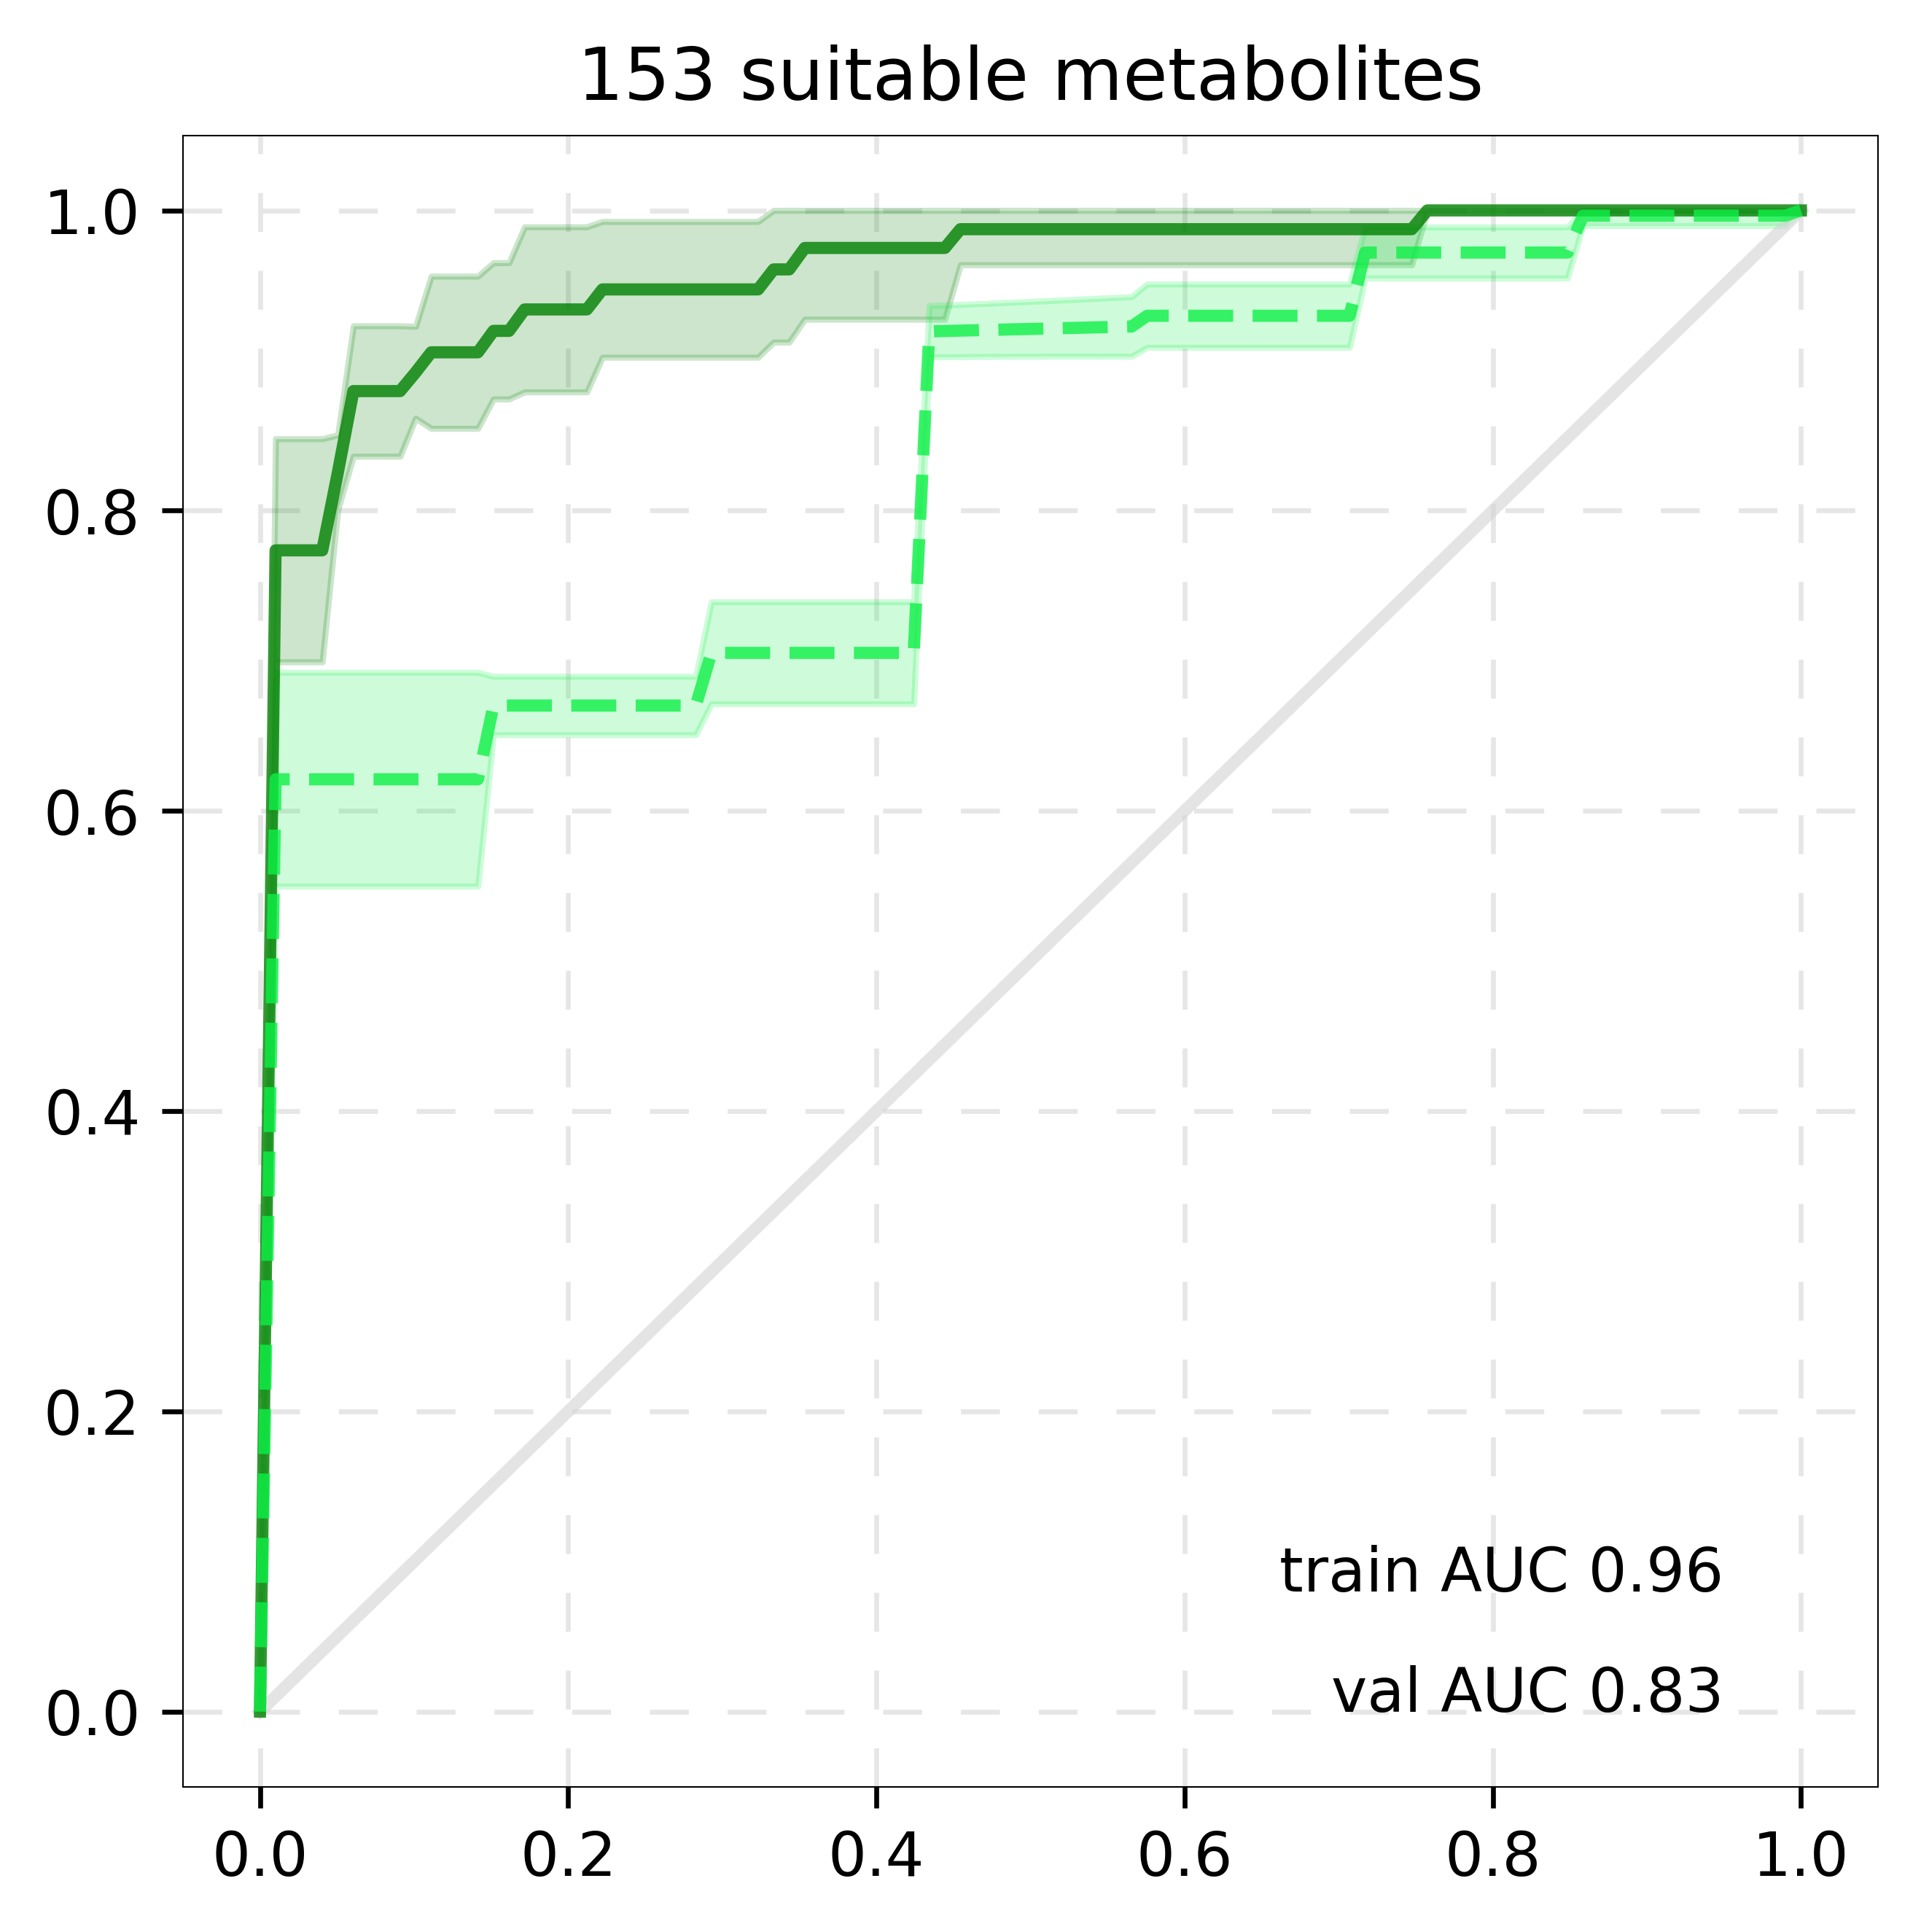

In [35]:
# all suitable metabolites
df_save = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_OEME, title=all_metab, modelname=modelname, drift=drift, hyper_param=hyper_param, plots=False, studies=studies)
df_results = pd.concat([df_results,df_save])

Results for rf and drift correction for all hydrophilic metabolites
Train Sensitivity:  0.8571428571428571  Specificity:  0.7294117647058824  Accuracy:  0.7928994082840237  Balanced Accuracy:  0.7932773109243698
Validation Sensitivity:  0.17605633802816903  Specificity:  0.9438202247191011  Accuracy:  0.603125  Balanced Accuracy:  0.5599382813736351
Joint Sensitivity:  0.4292035398230088  Specificity:  0.8745247148288973  Accuracy:  0.6687116564417178  Balanced Accuracy:  0.651864127325953


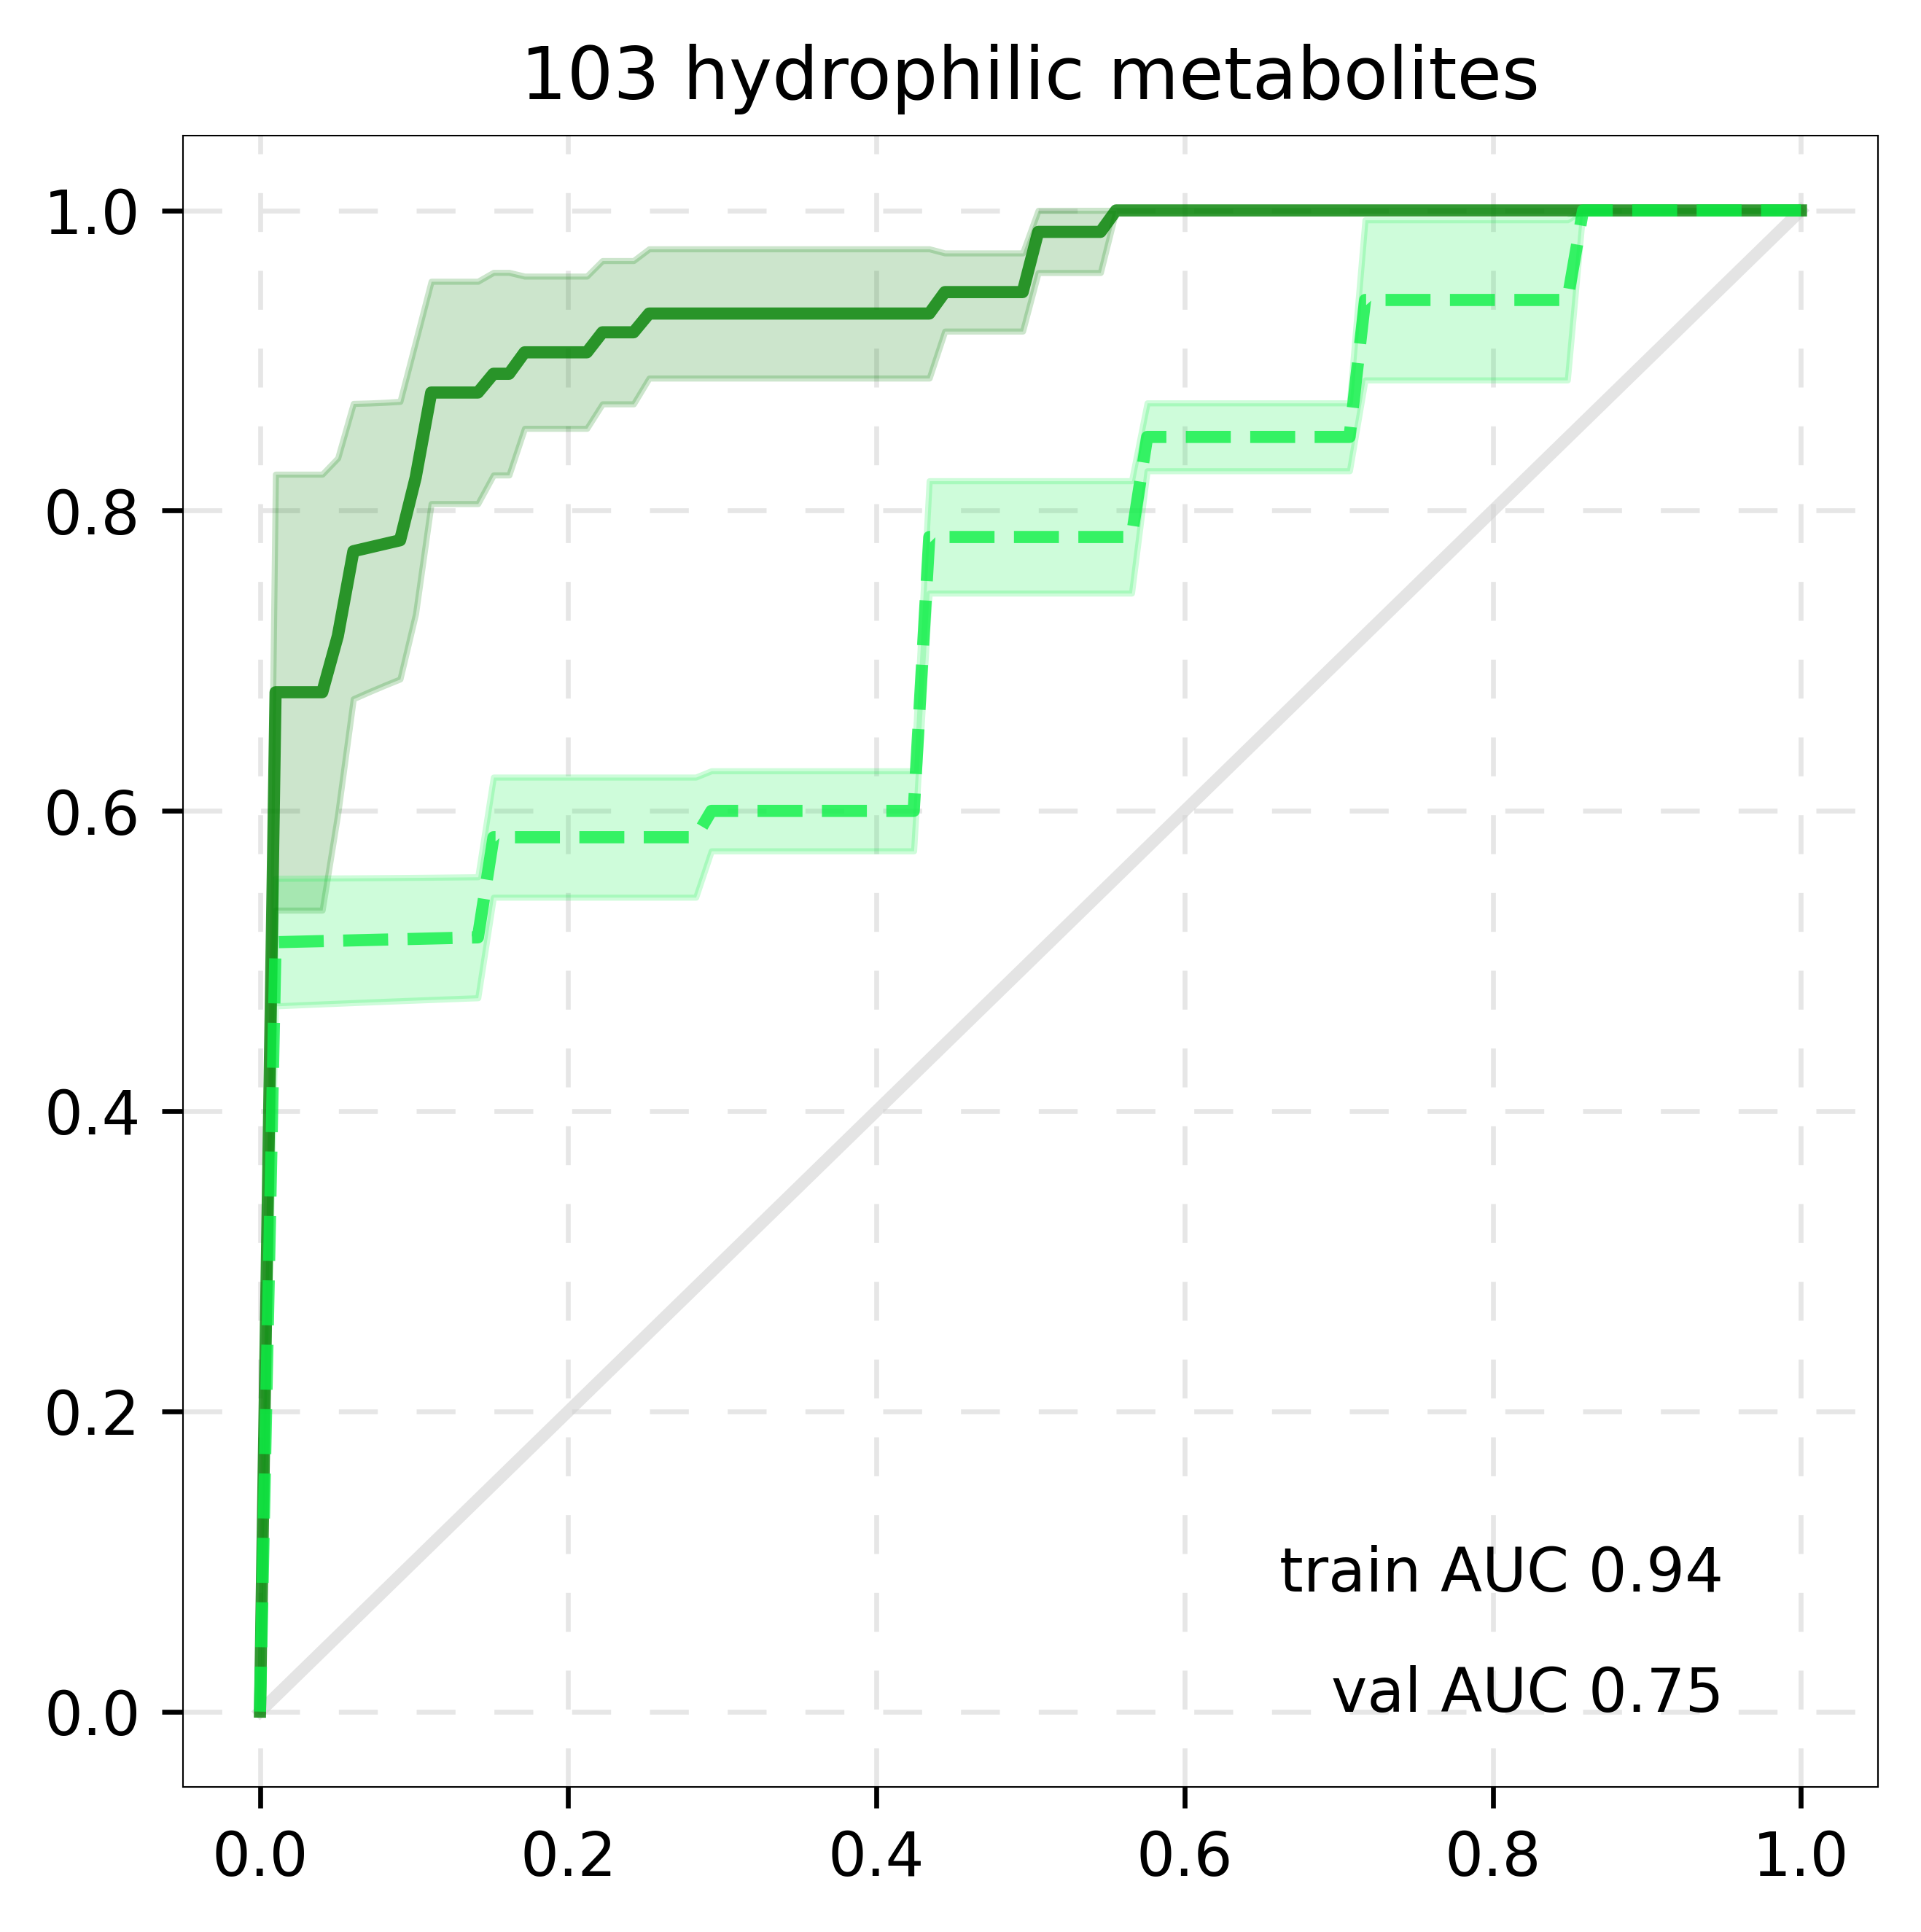

In [36]:
# all hydrophilic metabolites
df_save = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_hydrophilic_oeme, title=all_hyd, modelname=modelname, drift=drift, hyper_param=hyper_param, plots=False, studies=studies)
df_results = pd.concat([df_results,df_save])

Results for rf and drift correction for all lipophilic FFAs&lipids
Train Sensitivity:  0.9021739130434783  Specificity:  0.8441558441558441  Accuracy:  0.8757396449704143  Balanced Accuracy:  0.8731648785996612
Validation Sensitivity:  0.20833333333333331  Specificity:  1.0  Accuracy:  0.584375  Balanced Accuracy:  0.6041666666666666
Joint Sensitivity:  0.4538461538461539  Specificity:  0.9475982532751092  Accuracy:  0.6850715746421269  Balanced Accuracy:  0.7007222035606315


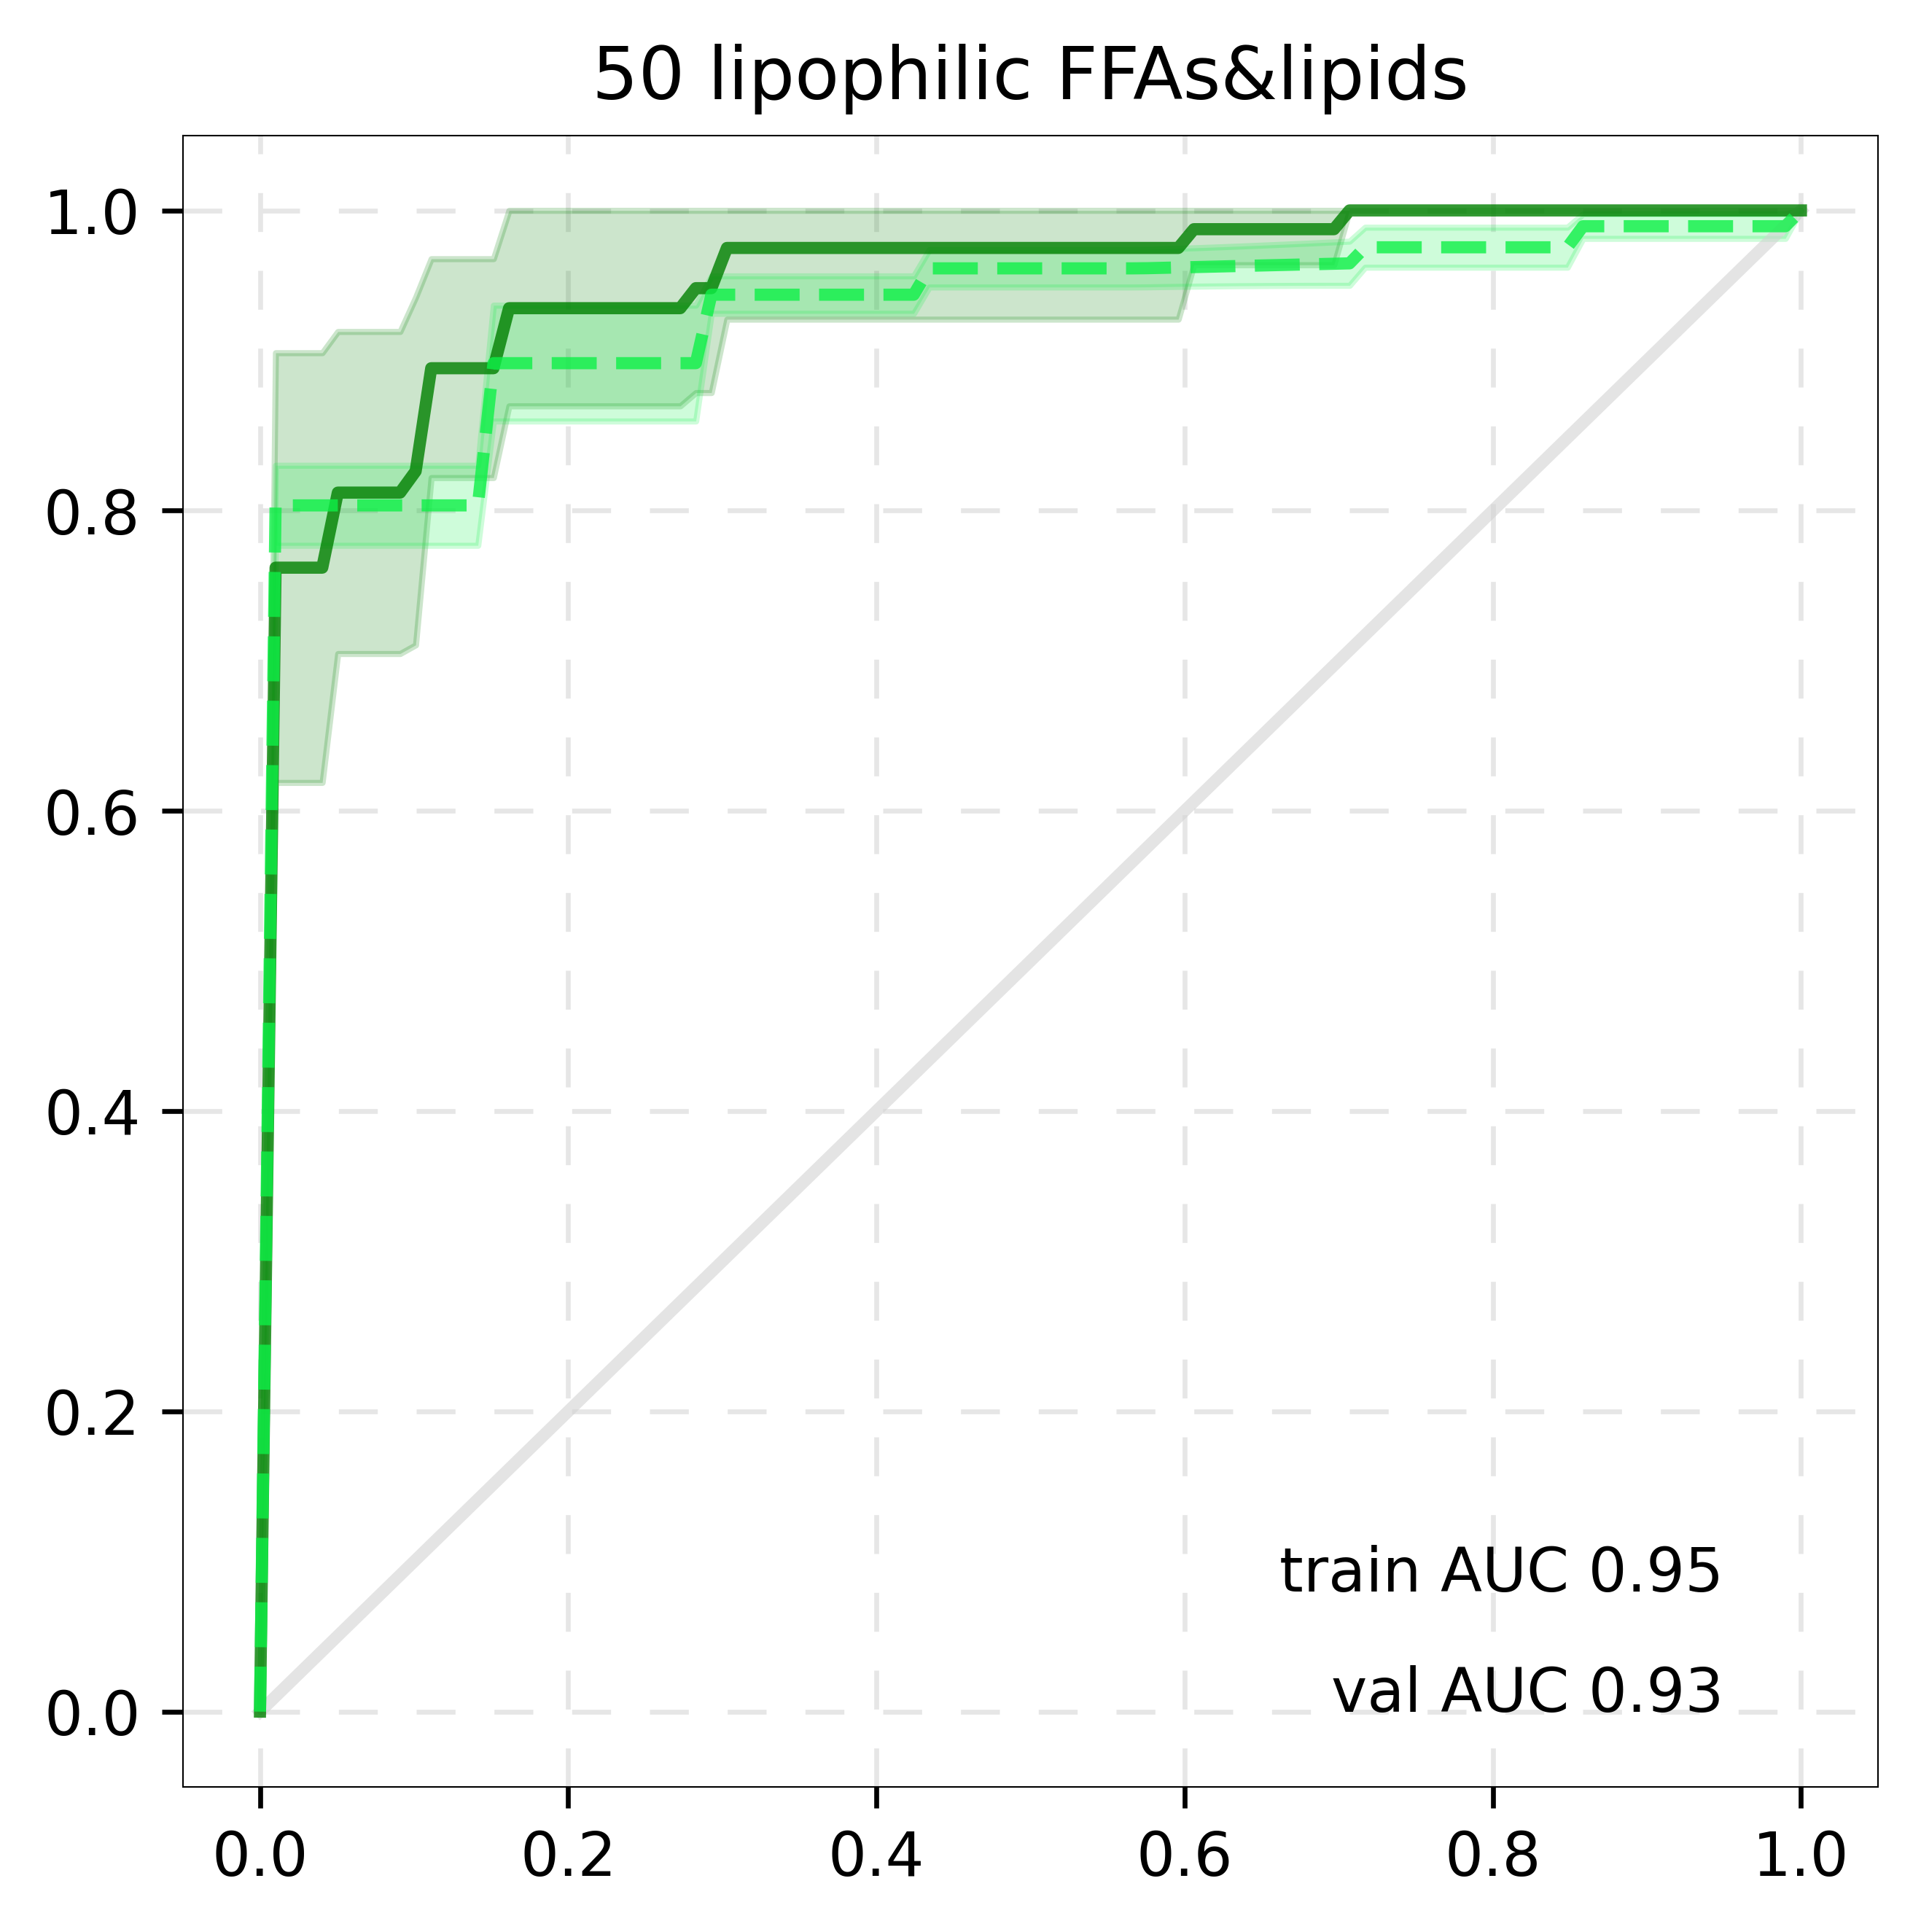

In [37]:
# all lipophilic metabolites
df_save = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_lipophilic_oeme, title=all_lip, modelname=modelname, drift=drift, hyper_param=hyper_param, plots=False, studies=studies)
df_results = pd.concat([df_results,df_save])

In [38]:
# len of column list without the first two entries (id and label)
print('All suitable metabolites:', len(col_OEME)-2)
print('All hydrophilic metabolites', len(col_hydrophilic_oeme)-2)
print('All lipophilic metabolites', len(col_lipophilic_oeme)-2)

All suitable metabolites: 153
All hydrophilic metabolites 103
All lipophilic metabolites 50


### calculate random forest with not drift corrected data

In [39]:
drift = 'drift'

Results for rf and drift for all suitable metabolites(not drift corrected)
Train Sensitivity:  0.9397590361445782  Specificity:  0.8023255813953489  Accuracy:  0.8698224852071005  Balanced Accuracy:  0.8710423087699636
Validation Sensitivity:  0.24074074074074078  Specificity:  0.9575471698113208  Accuracy:  0.7156250000000001  Balanced Accuracy:  0.5991439552760308
Joint Sensitivity:  0.5445026178010471  Specificity:  0.9127516778523489  Accuracy:  0.768916155419223  Balanced Accuracy:  0.728627147826698


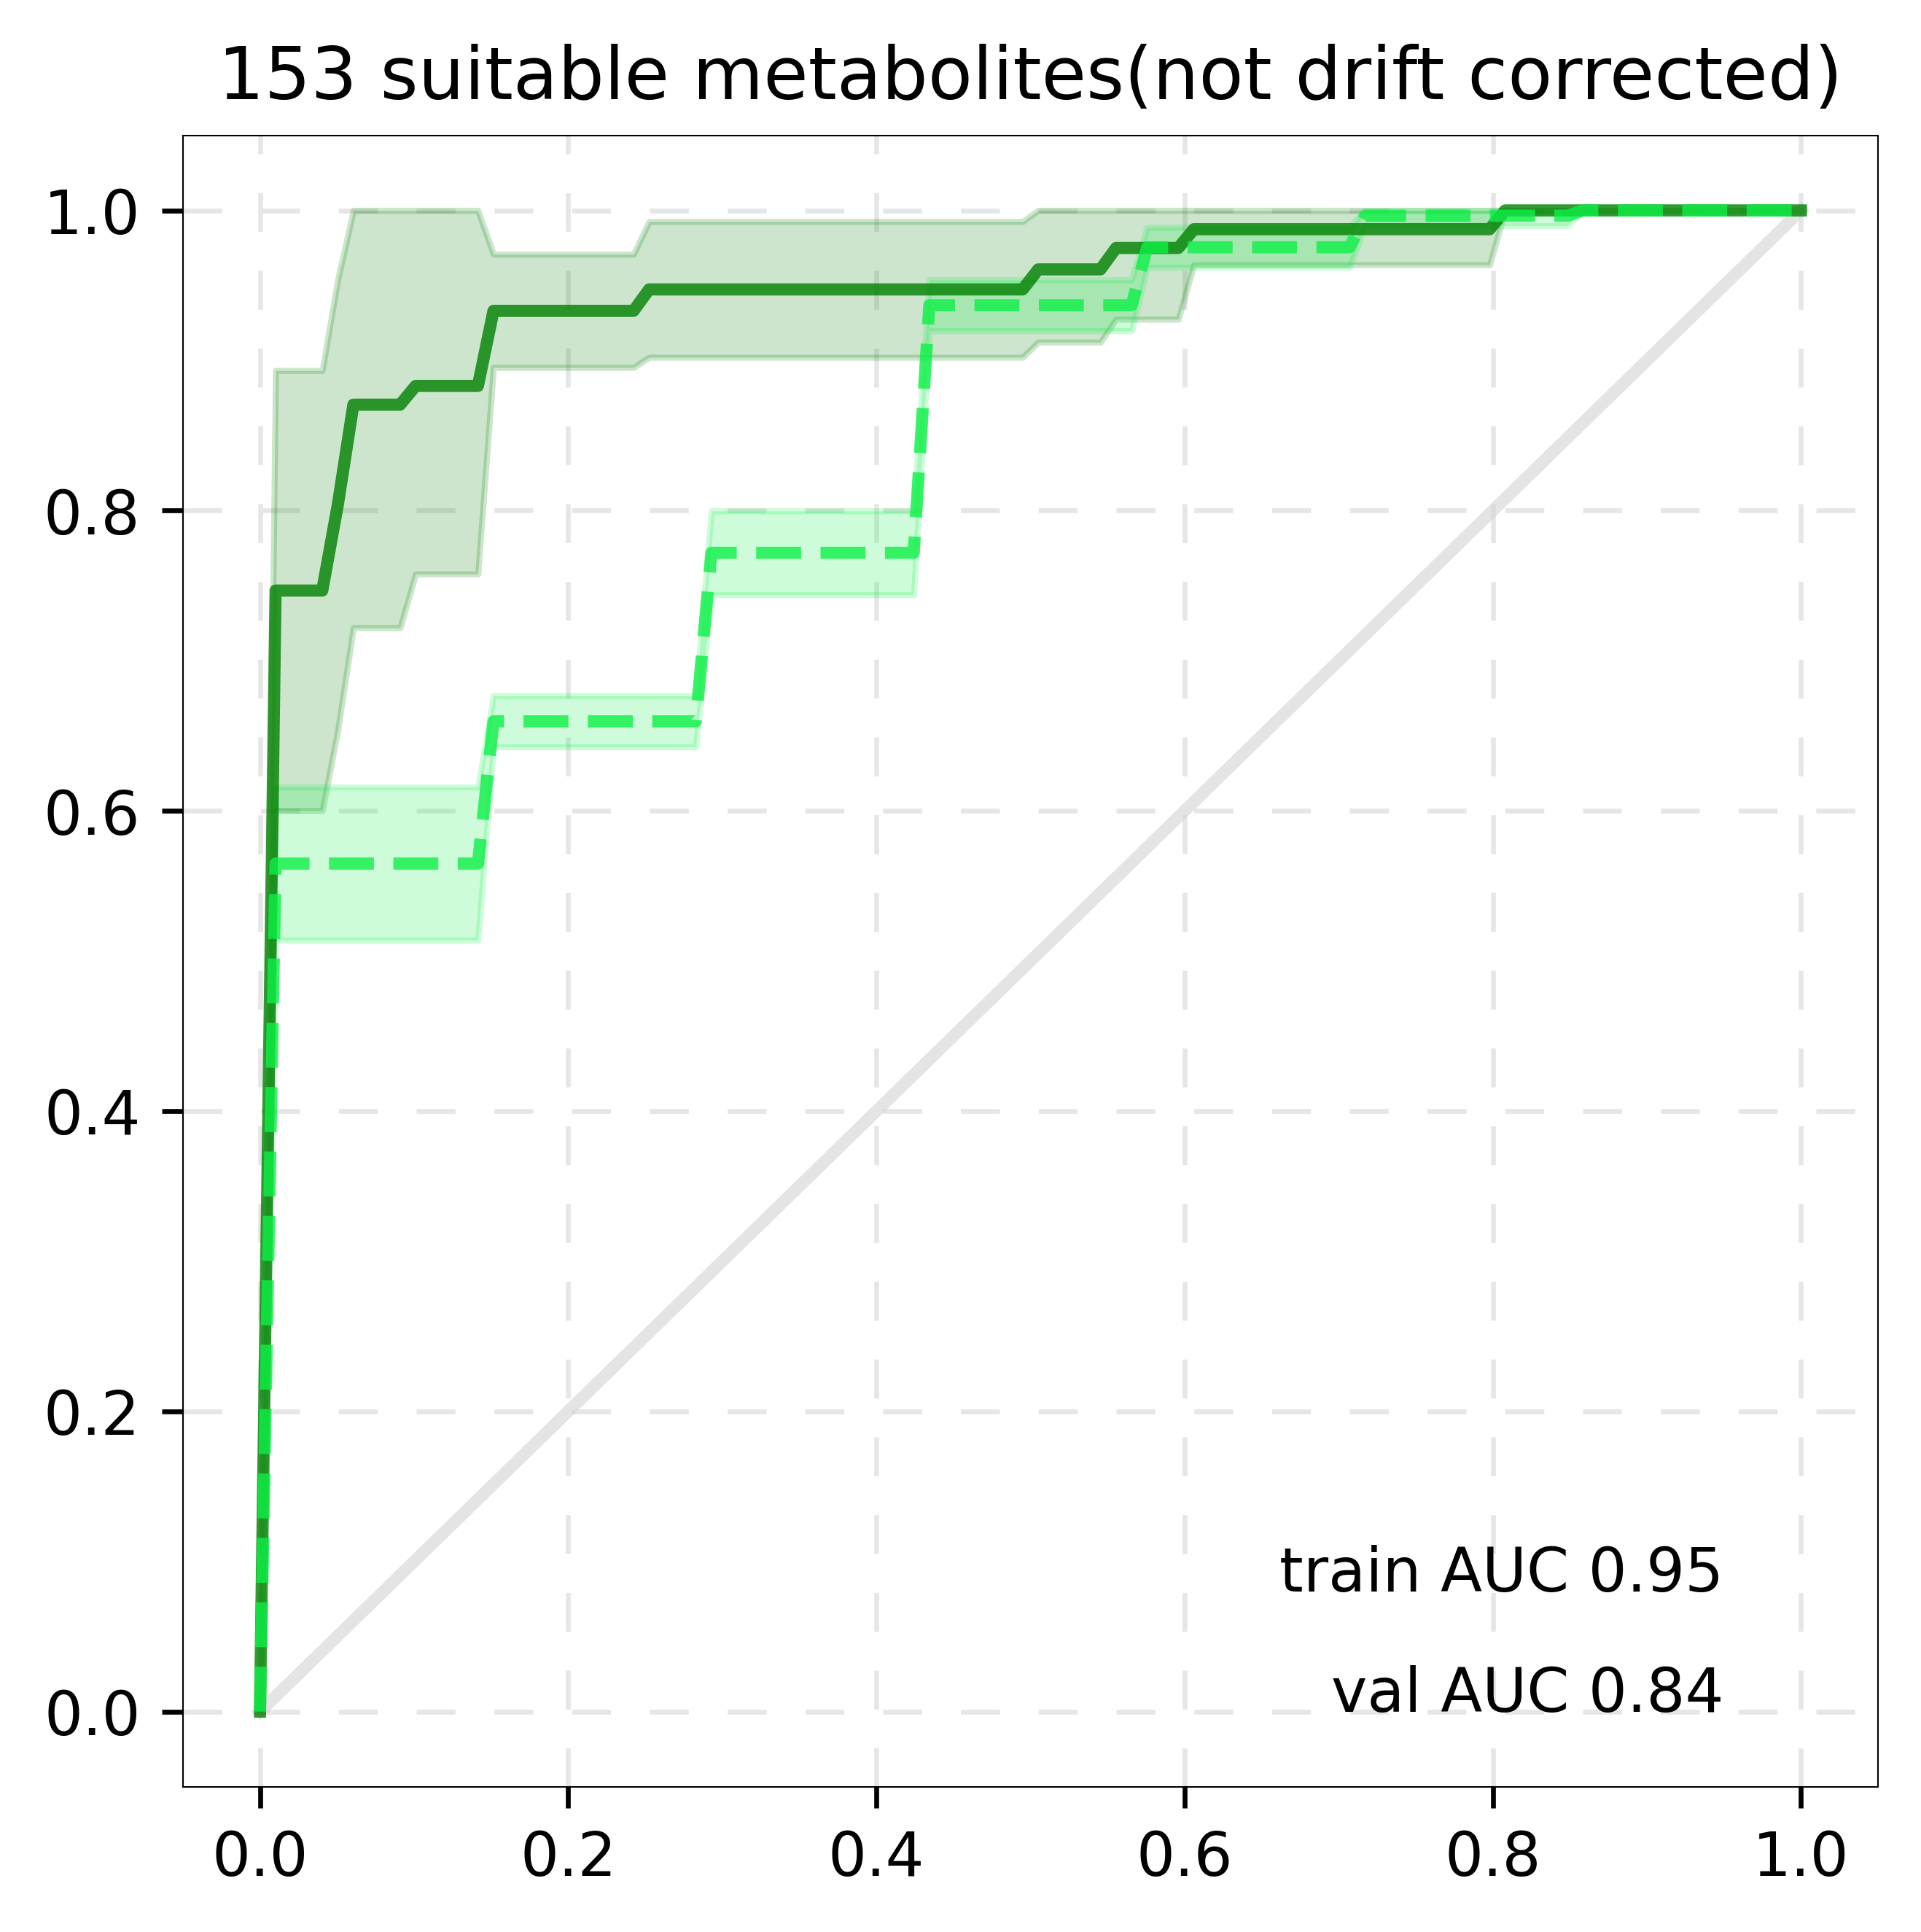

In [40]:
# all suitable metabolites
df_save = test_model(df_train_new, df_val_new, col_OE, title=all_metab+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param, plots=False, studies=studies)
df_results = pd.concat([df_results,df_save])

Results for rf and drift for all hydrophilic metabolites(not drift corrected)
Train Sensitivity:  0.872093023255814  Specificity:  0.7590361445783131  Accuracy:  0.8165680473372782  Balanced Accuracy:  0.8155645839170635
Validation Sensitivity:  0.1810344827586207  Specificity:  0.9313725490196079  Accuracy:  0.659375  Balanced Accuracy:  0.5562035158891143
Joint Sensitivity:  0.4752475247524752  Specificity:  0.8815331010452963  Accuracy:  0.7137014314928425  Balanced Accuracy:  0.6783903128988857


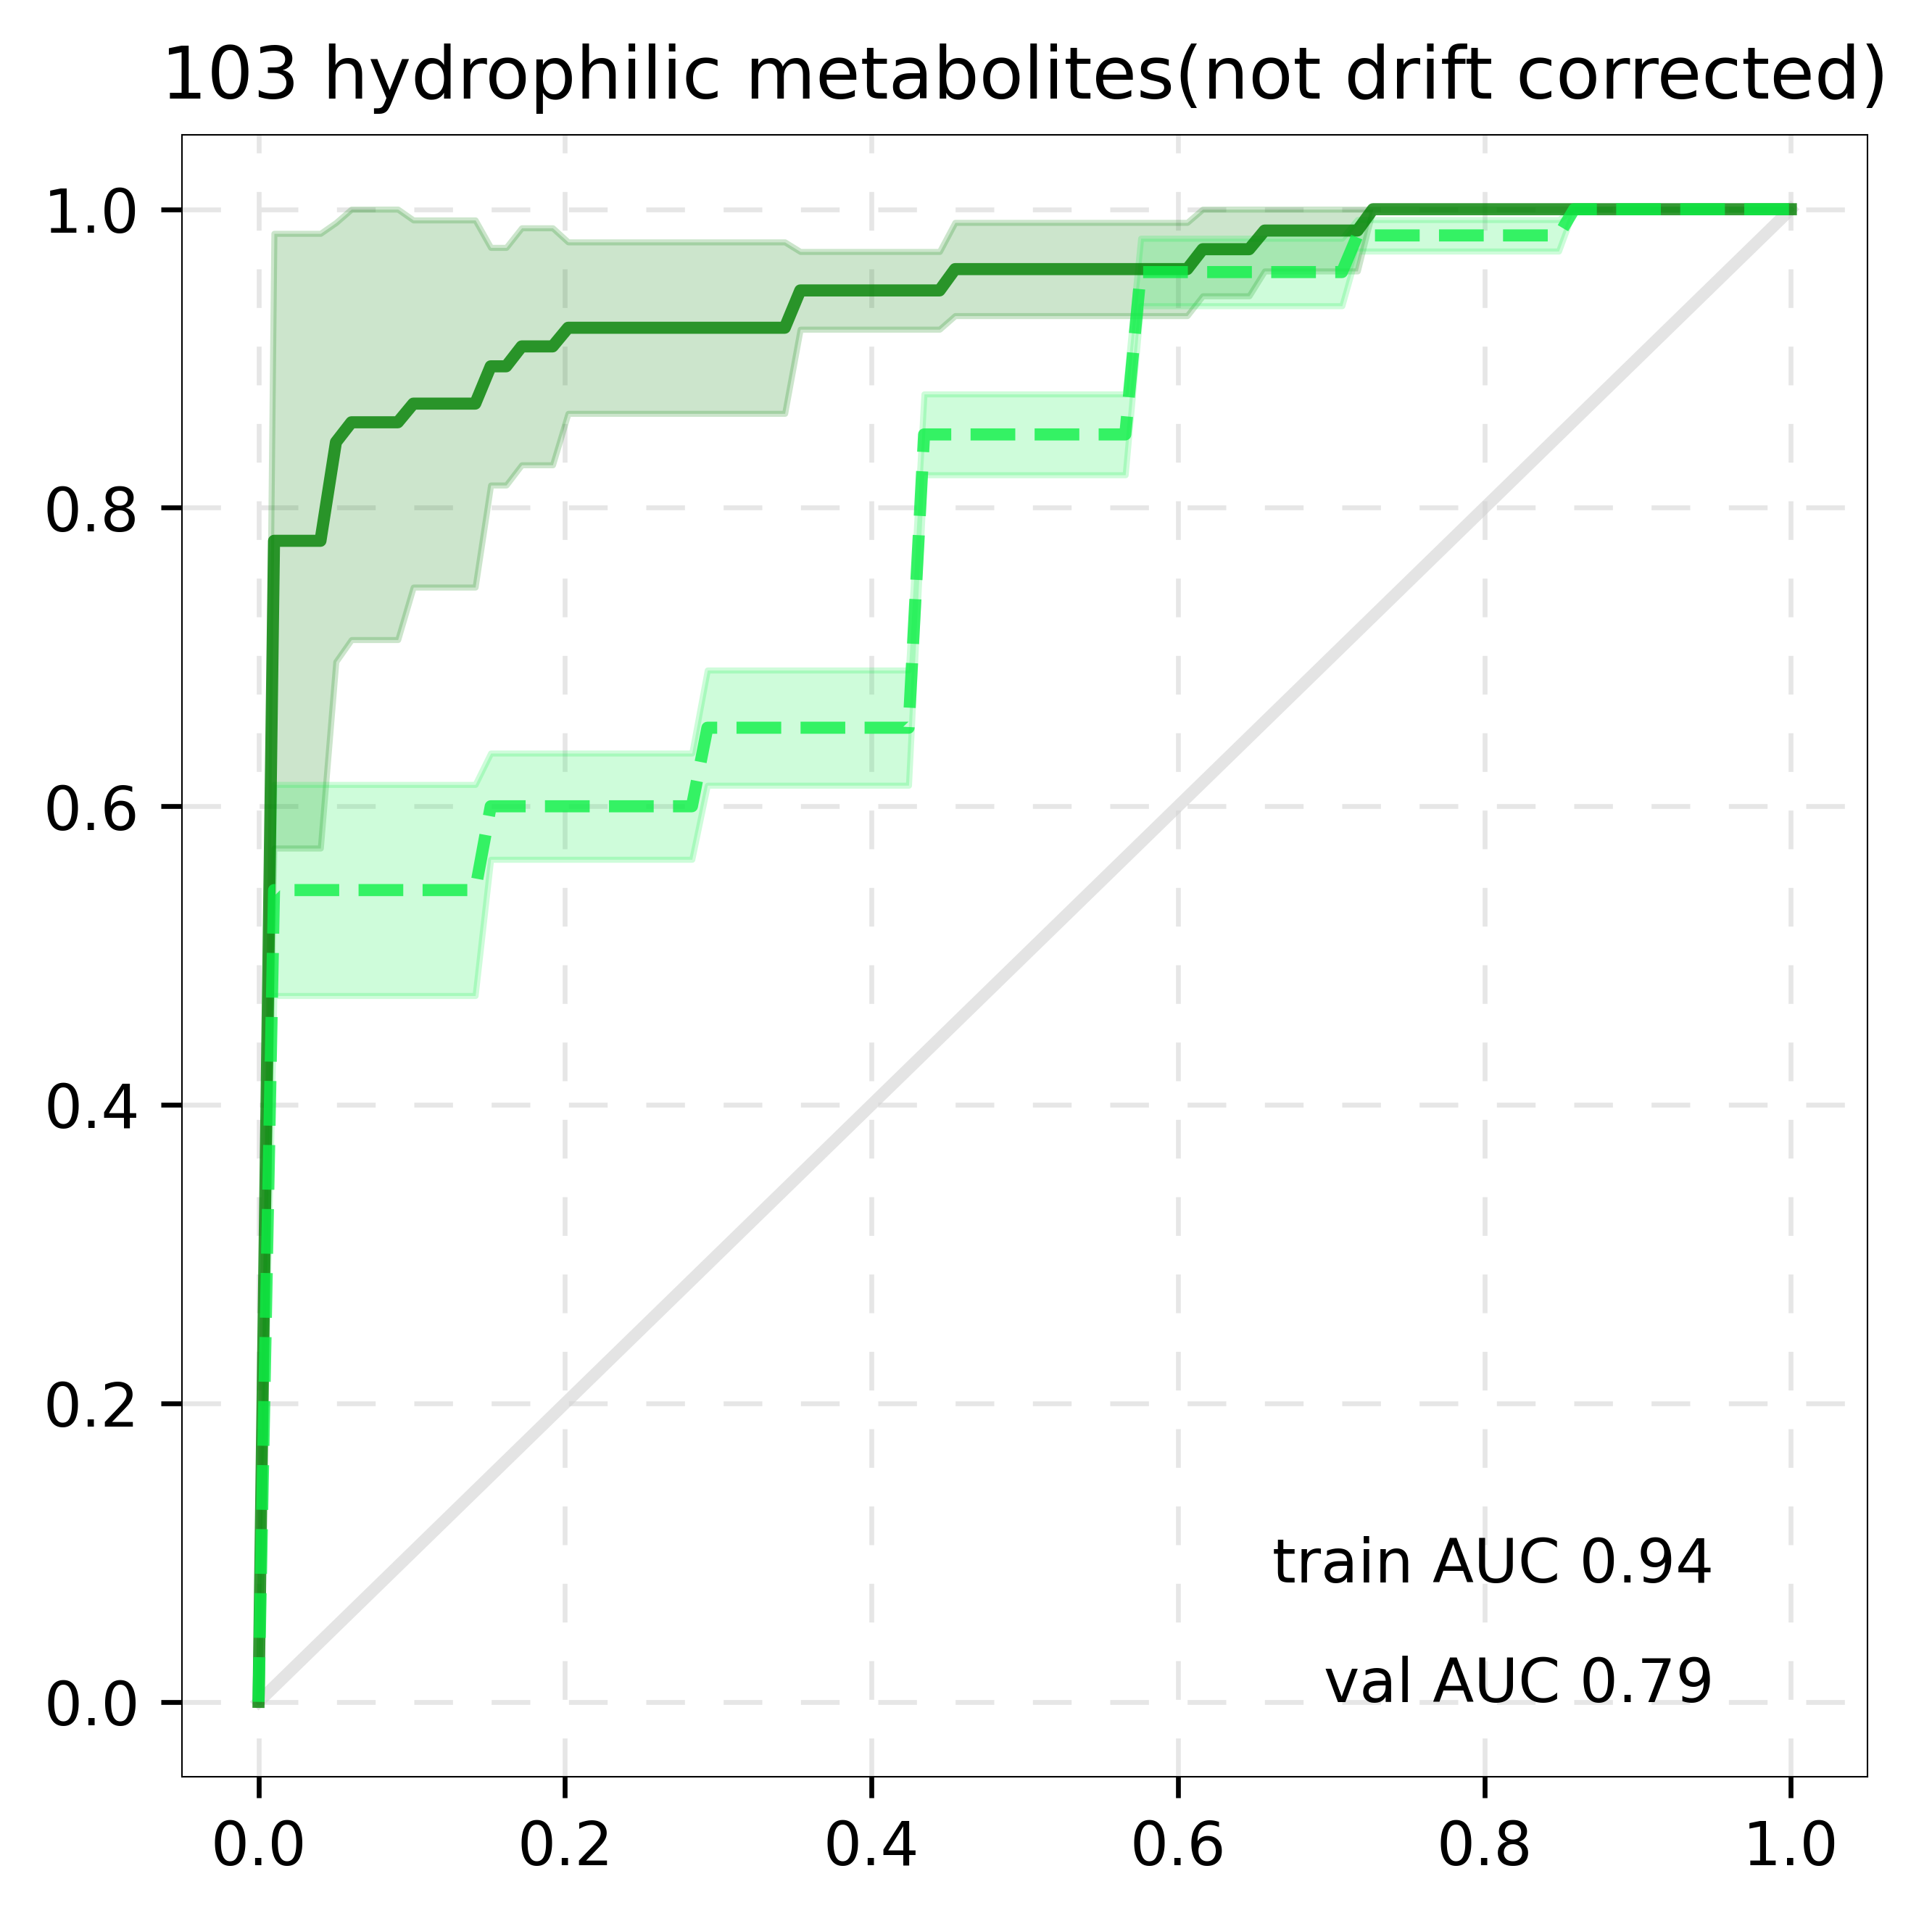

In [41]:
# all hydrophilic metabolites
df_save = test_model(df_train_new, df_val_new, col_hydrophilic_oe, title=all_hyd+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param, plots=False, studies=studies)
df_results = pd.concat([df_results,df_save])

Results for rf and drift for all lipophilic FFAs&lipids(not drift corrected)
Train Sensitivity:  0.8961038961038962  Specificity:  0.717391304347826  Accuracy:  0.7988165680473374  Balanced Accuracy:  0.8067476002258611
Validation Sensitivity:  0.33663366336633666  Specificity:  0.9954337899543378  Accuracy:  0.7875  Balanced Accuracy:  0.6660337266603372
Joint Sensitivity:  0.5786516853932584  Specificity:  0.9131832797427653  Accuracy:  0.7914110429447855  Balanced Accuracy:  0.7459174825680118


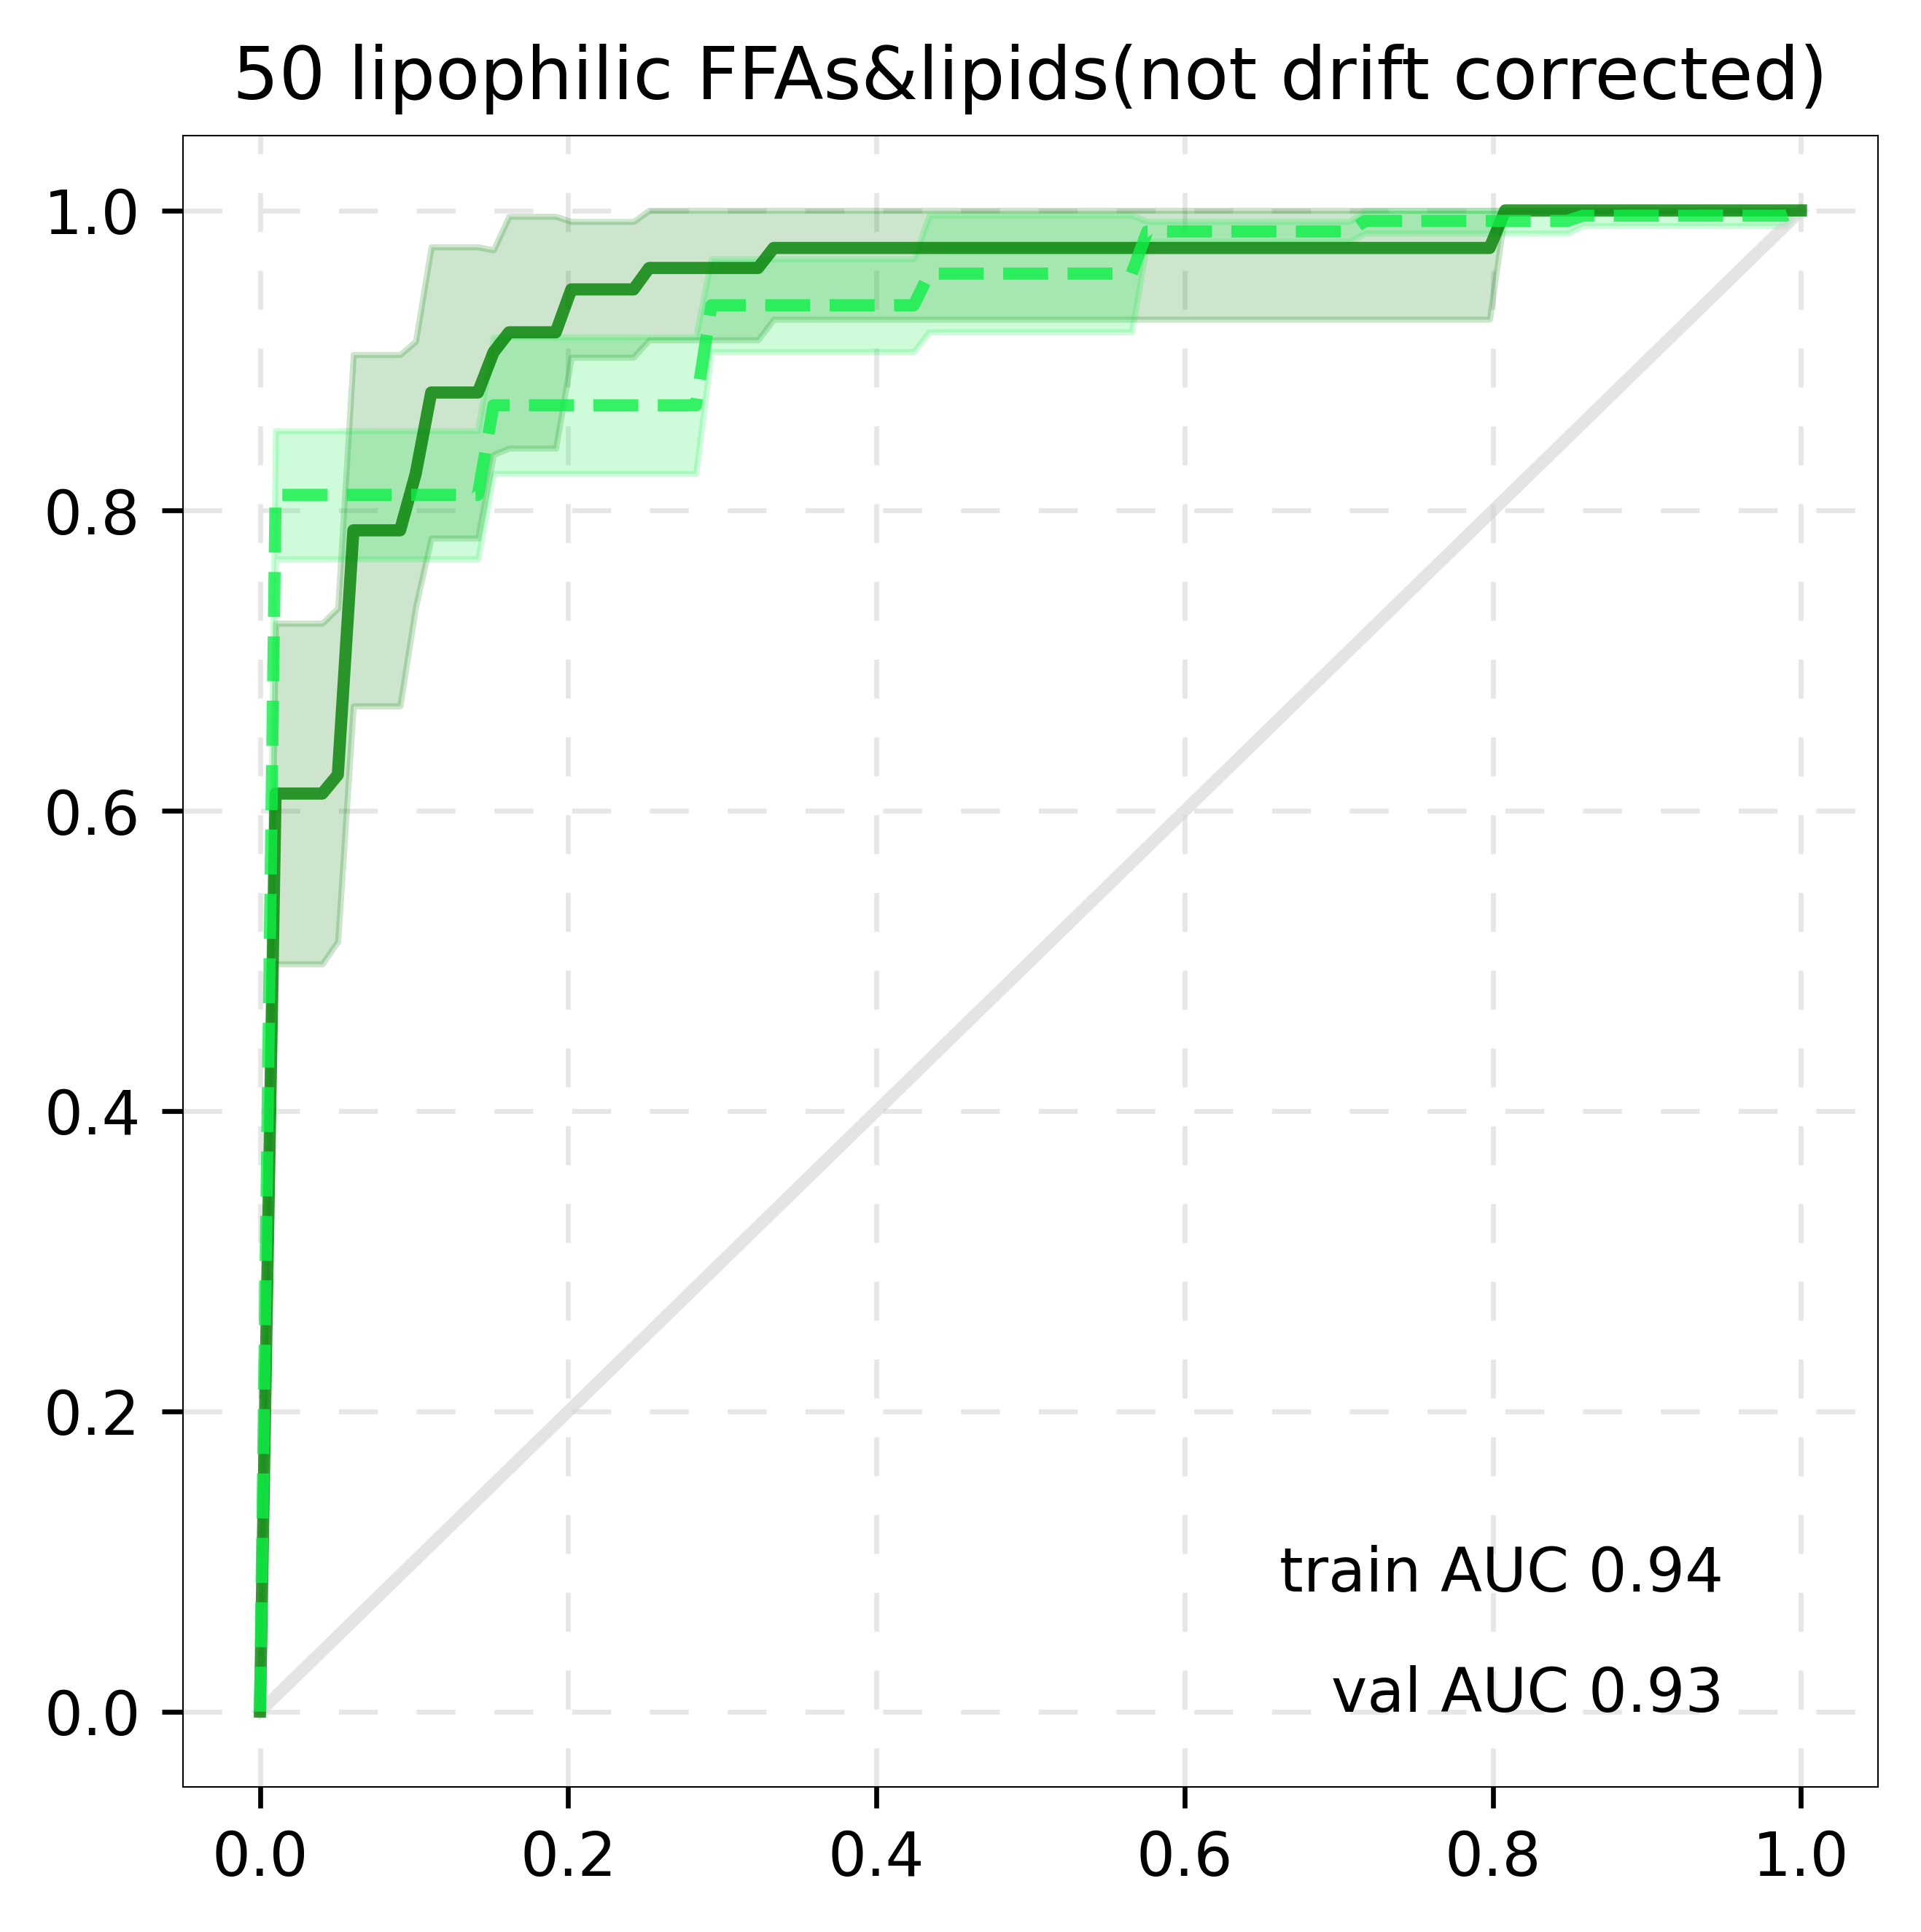

In [42]:
# all lipophilic metabolites
df_save = test_model(df_train_new, df_val_new, col_lipophilic_oe, title=all_lip+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param, plots=False, studies=studies)
df_results = pd.concat([df_results,df_save])

### calculate XGB with drift corrected data

In [43]:
hyper_param = [0.01,5,3001]
modelname = 'xg'
drift='drift correction'

Results for xg and drift correction for all suitable metabolites
Train Sensitivity:  0.8333333333333334  Specificity:  0.8507462686567164  Accuracy:  0.8402366863905326  Balanced Accuracy:  0.842039800995025
Validation Sensitivity:  0.19021739130434784  Specificity:  1.0  Accuracy:  0.534375  Balanced Accuracy:  0.595108695652174
Joint Sensitivity:  0.4195804195804196  Specificity:  0.9507389162561576  Accuracy:  0.640081799591002  Balanced Accuracy:  0.6851596679182885


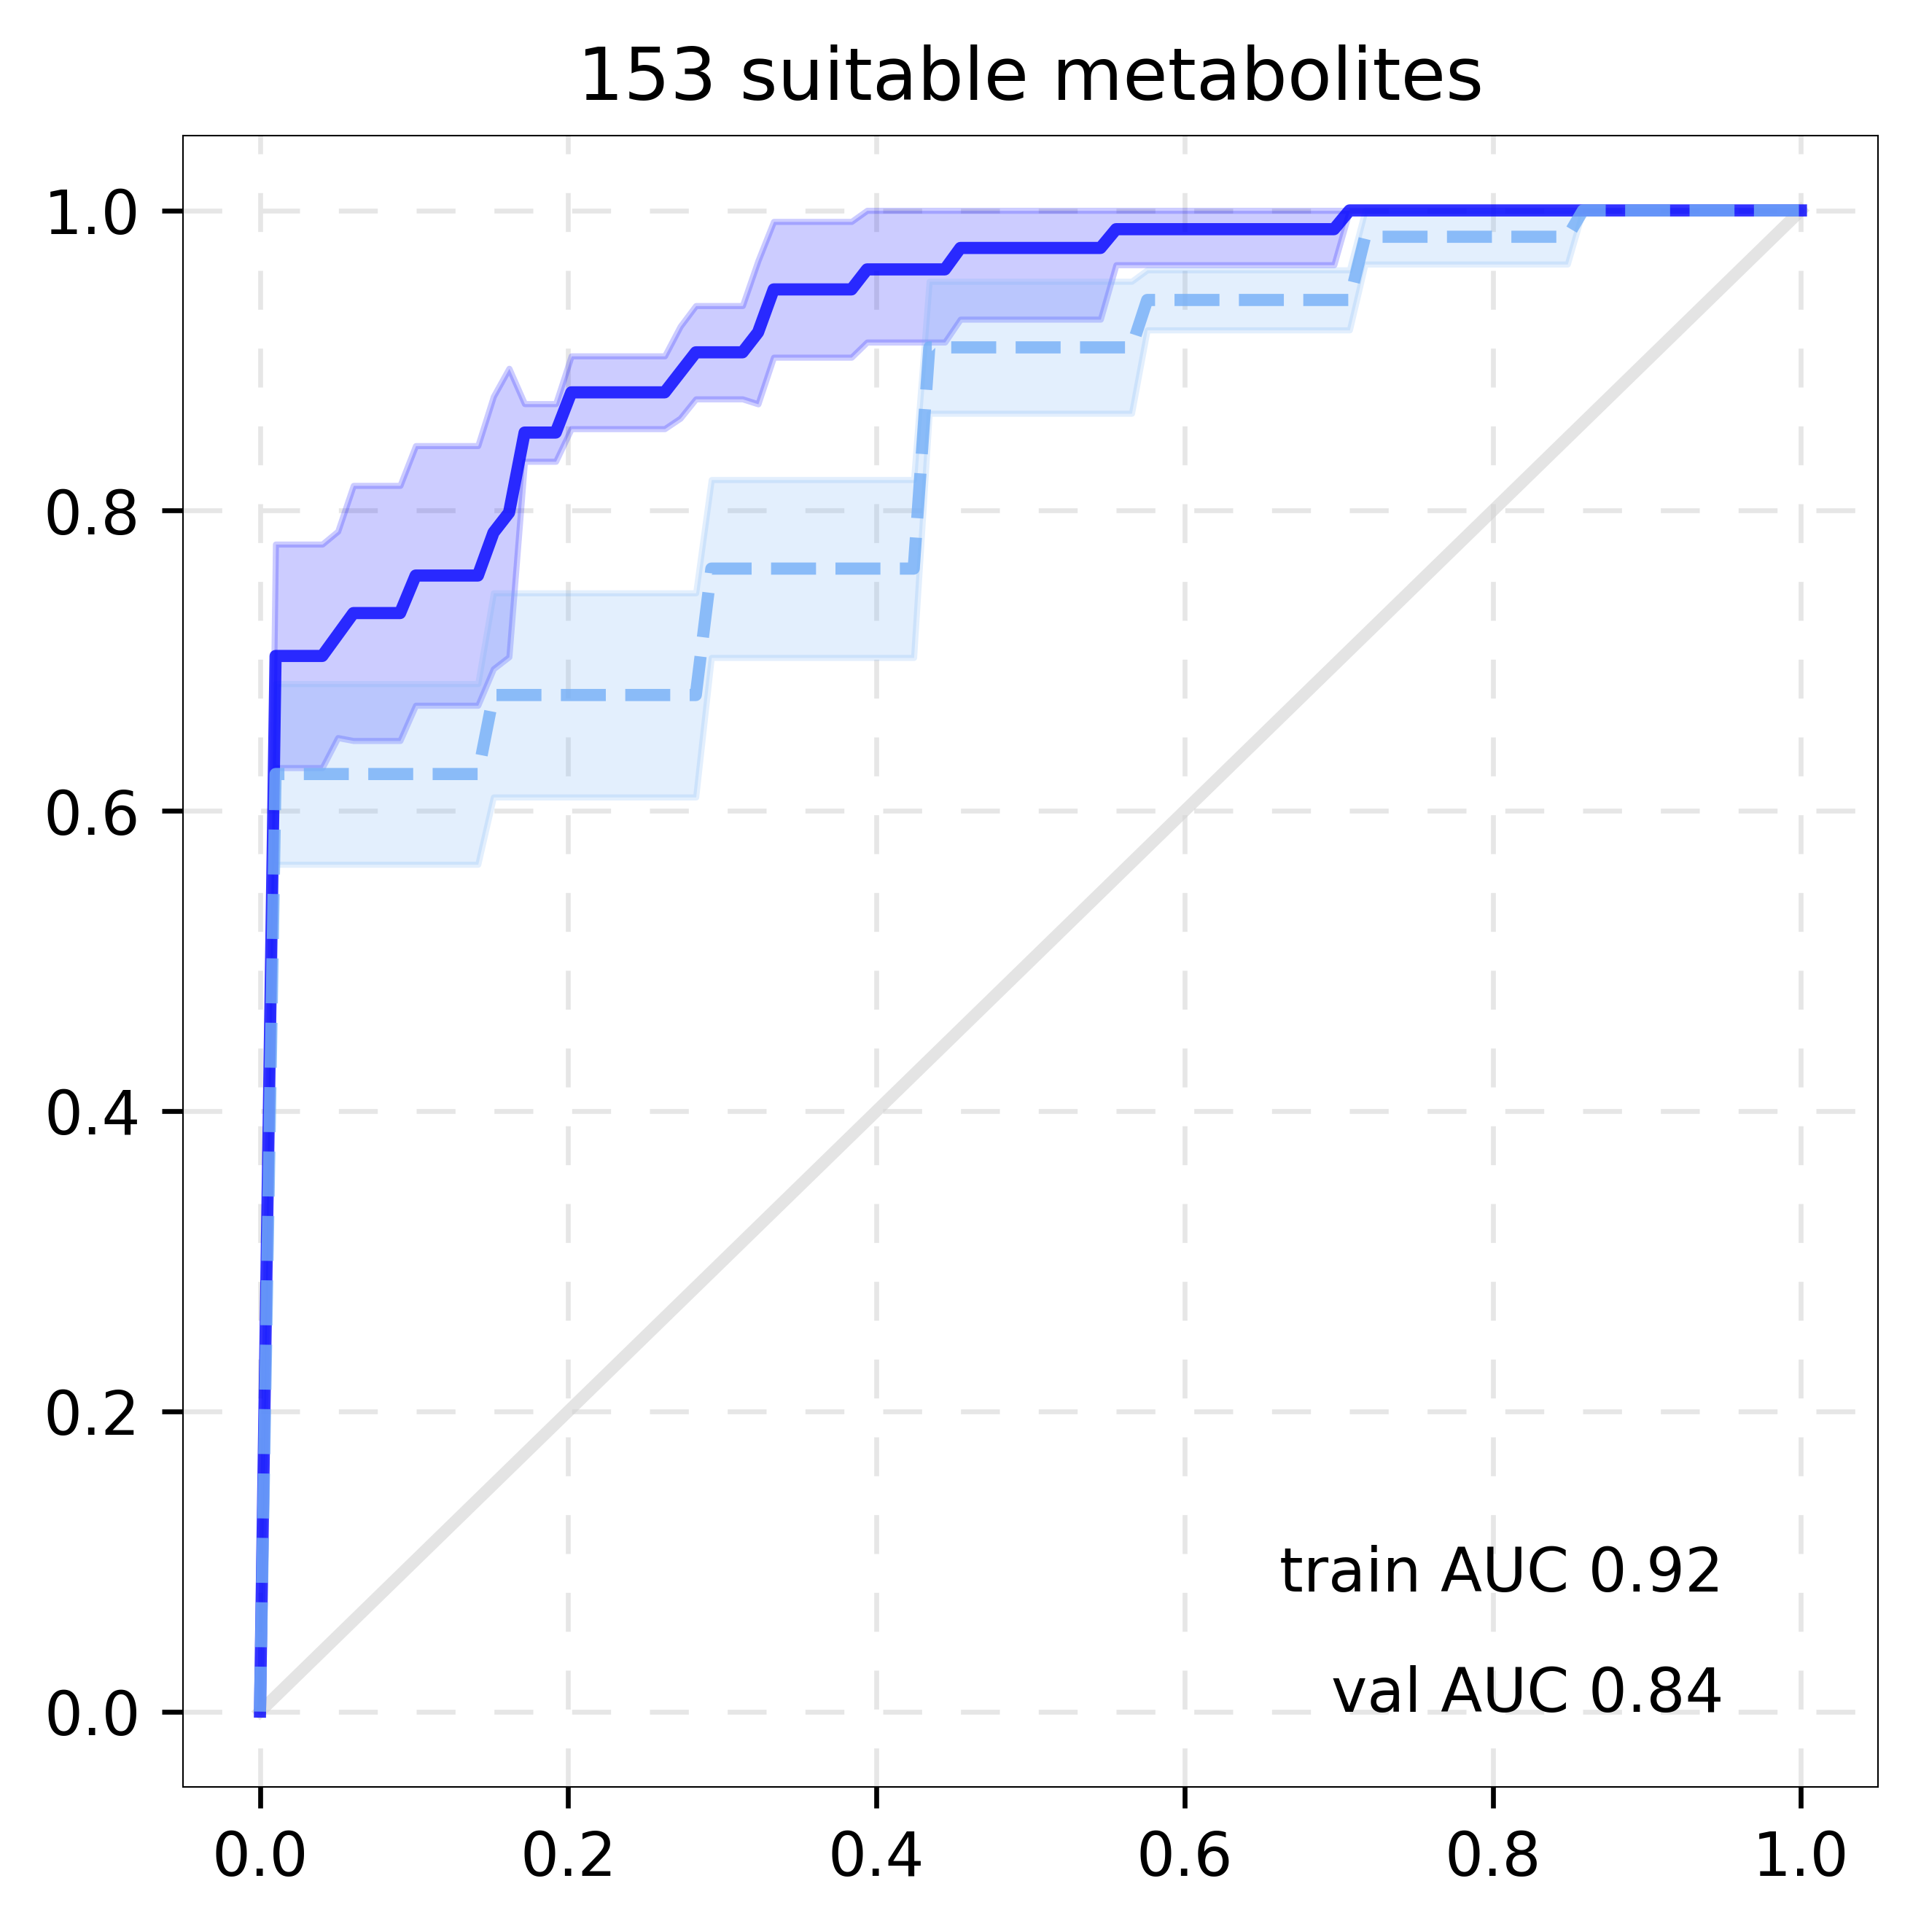

In [44]:
# all suitable metabolites
df_save = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_OEME, title=all_metab, modelname=modelname, drift=drift, hyper_param=hyper_param, plots=False, studies=studies)
df_results = pd.concat([df_results,df_save])

only metabolites

Results for xg and drift correction for all hydrophilic metabolites
Train Sensitivity:  0.8421052631578947  Specificity:  0.7972972972972973  Accuracy:  0.8224852071005918  Balanced Accuracy:  0.819701280227596
Validation Sensitivity:  0.20231213872832368  Specificity:  1.0  Accuracy:  0.56875  Balanced Accuracy:  0.6011560693641619
Joint Sensitivity:  0.42910447761194026  Specificity:  0.9321266968325792  Accuracy:  0.656441717791411  Balanced Accuracy:  0.6806155872222597


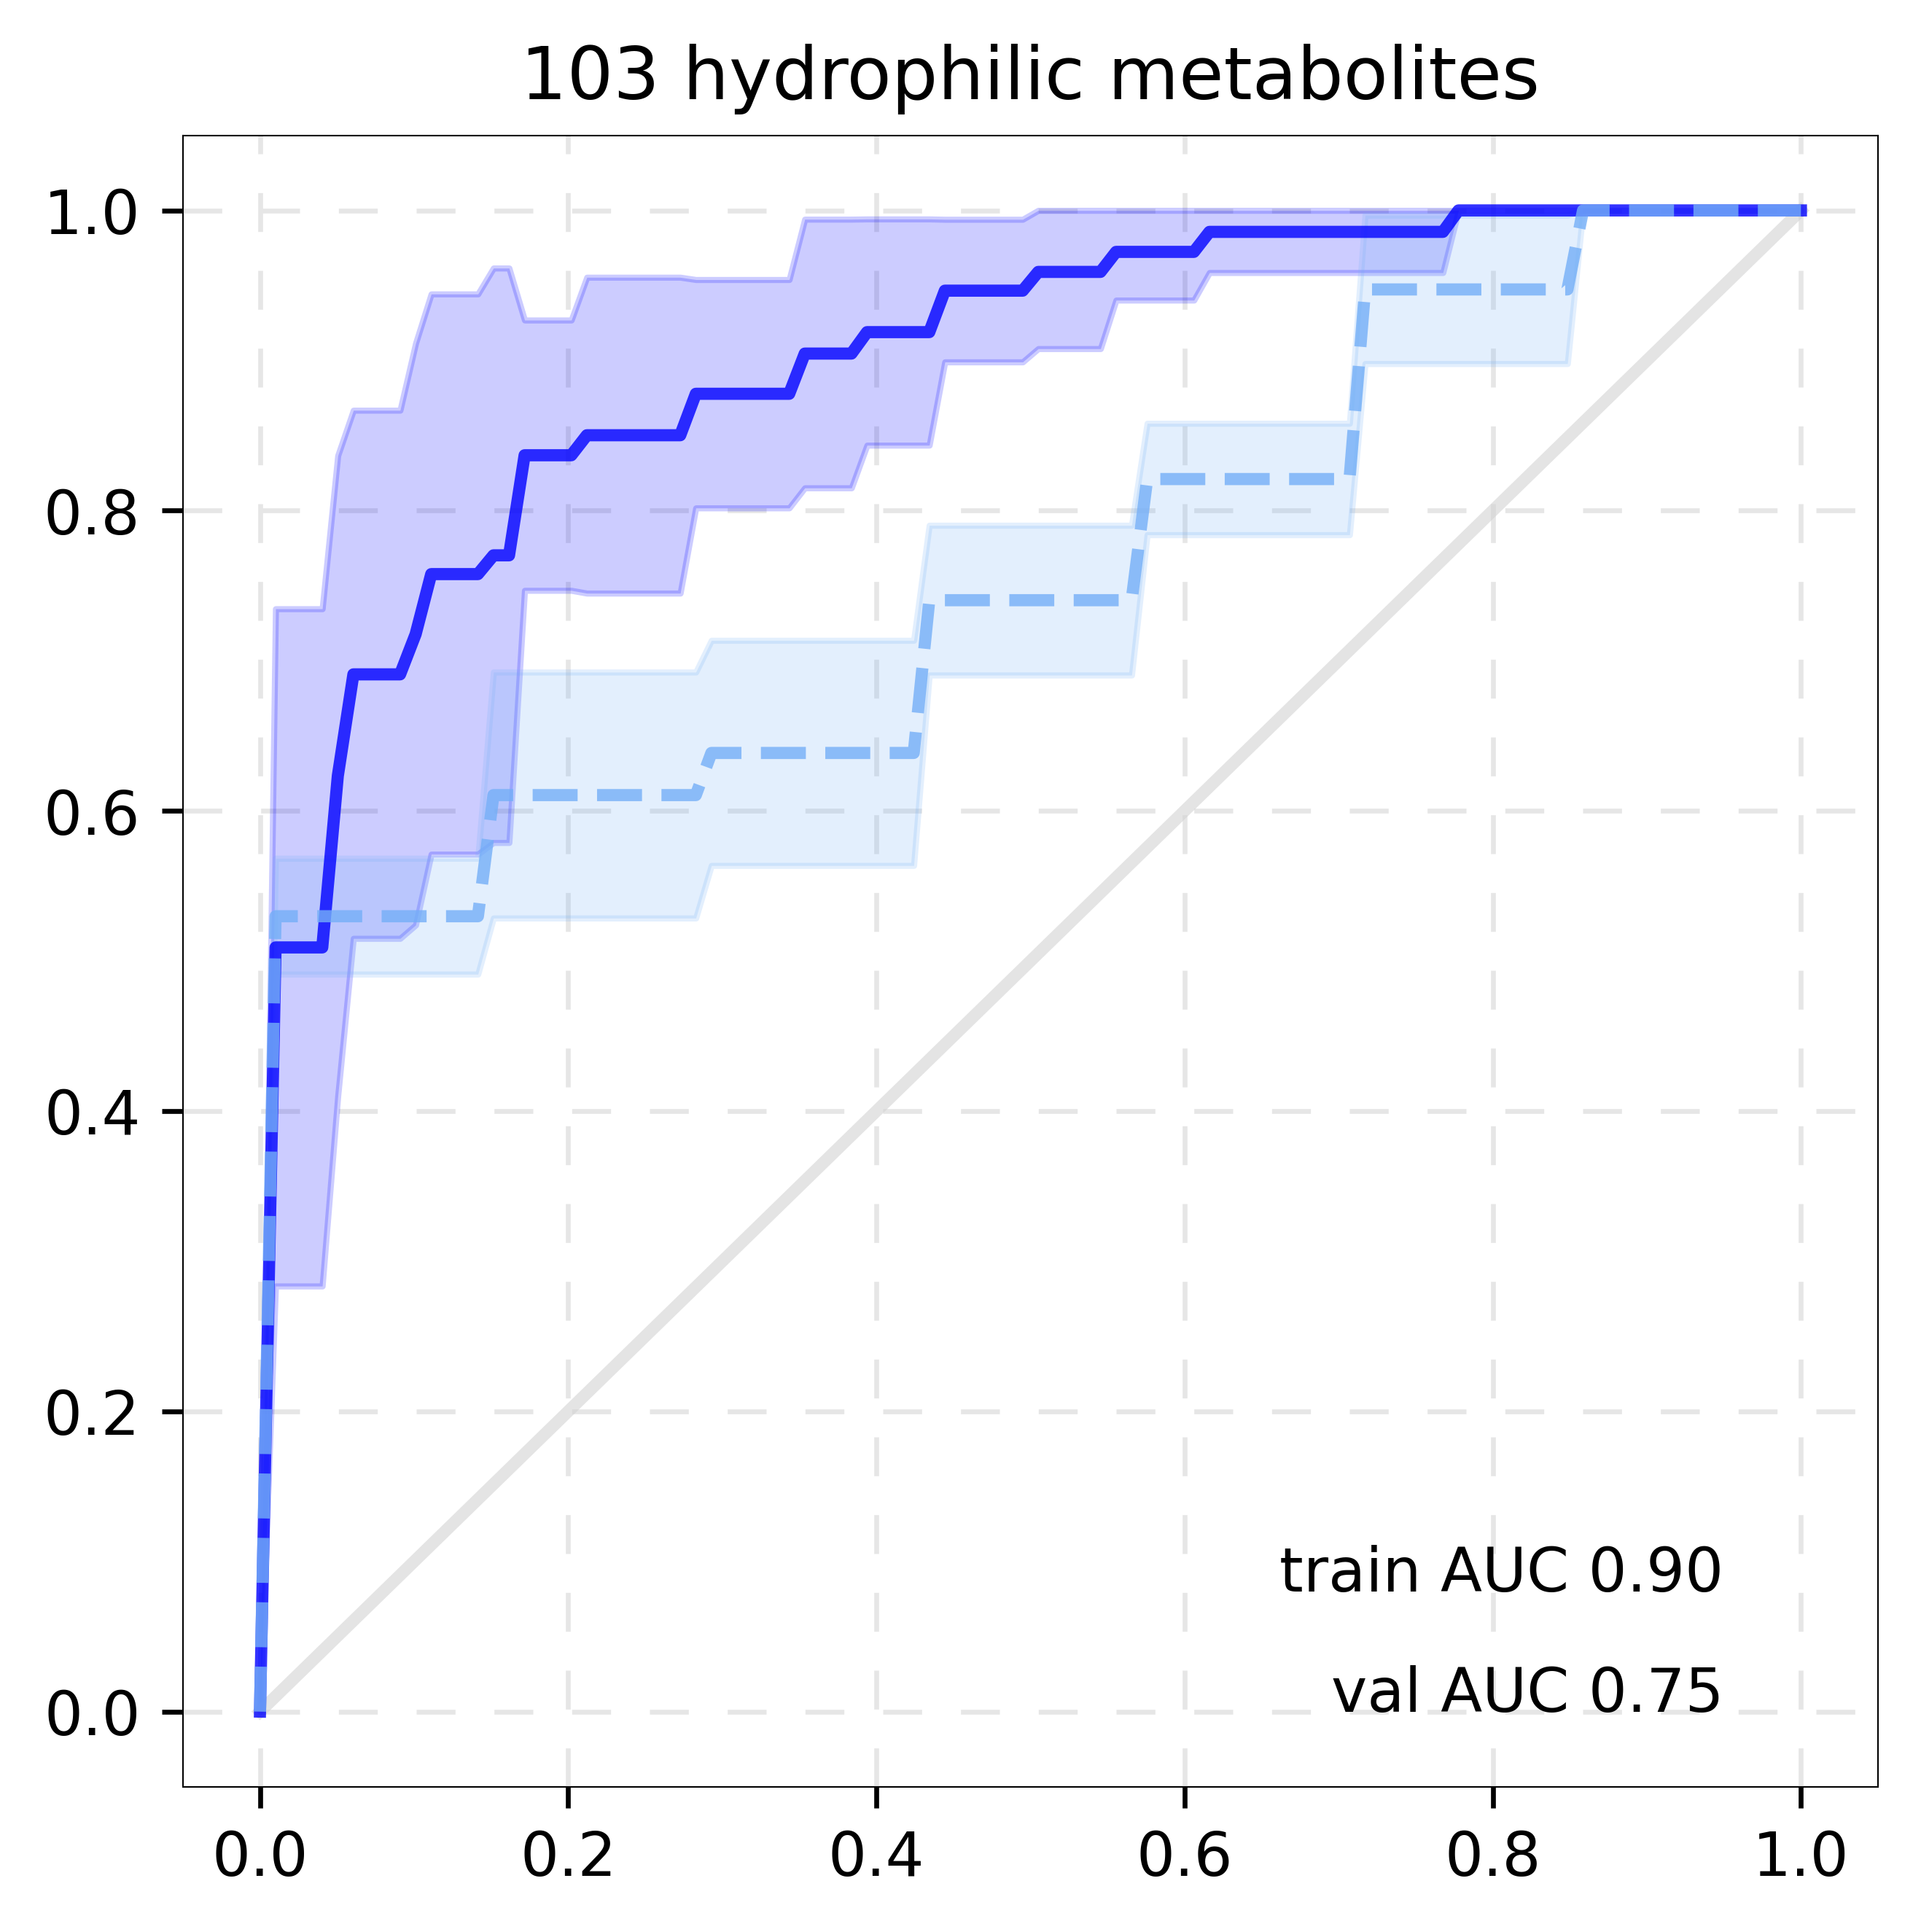

In [45]:
# all hydrophilic metabolites
df_save = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_hydrophilic_oeme, title=all_hyd, modelname=modelname, drift=drift, hyper_param=hyper_param, plots=False, studies=studies)
df_results = pd.concat([df_results,df_save])

no metabolites

Results for xg and drift correction for all lipophilic FFAs&lipids
Train Sensitivity:  0.8252427184466019  Specificity:  0.8484848484848485  Accuracy:  0.834319526627219  Balanced Accuracy:  0.8368637834657252
Validation Sensitivity:  0.17766497461928935  Specificity:  1.0  Accuracy:  0.49375  Balanced Accuracy:  0.5888324873096447
Joint Sensitivity:  0.4  Specificity:  0.9470899470899471  Accuracy:  0.6114519427402862  Balanced Accuracy:  0.6735449735449736


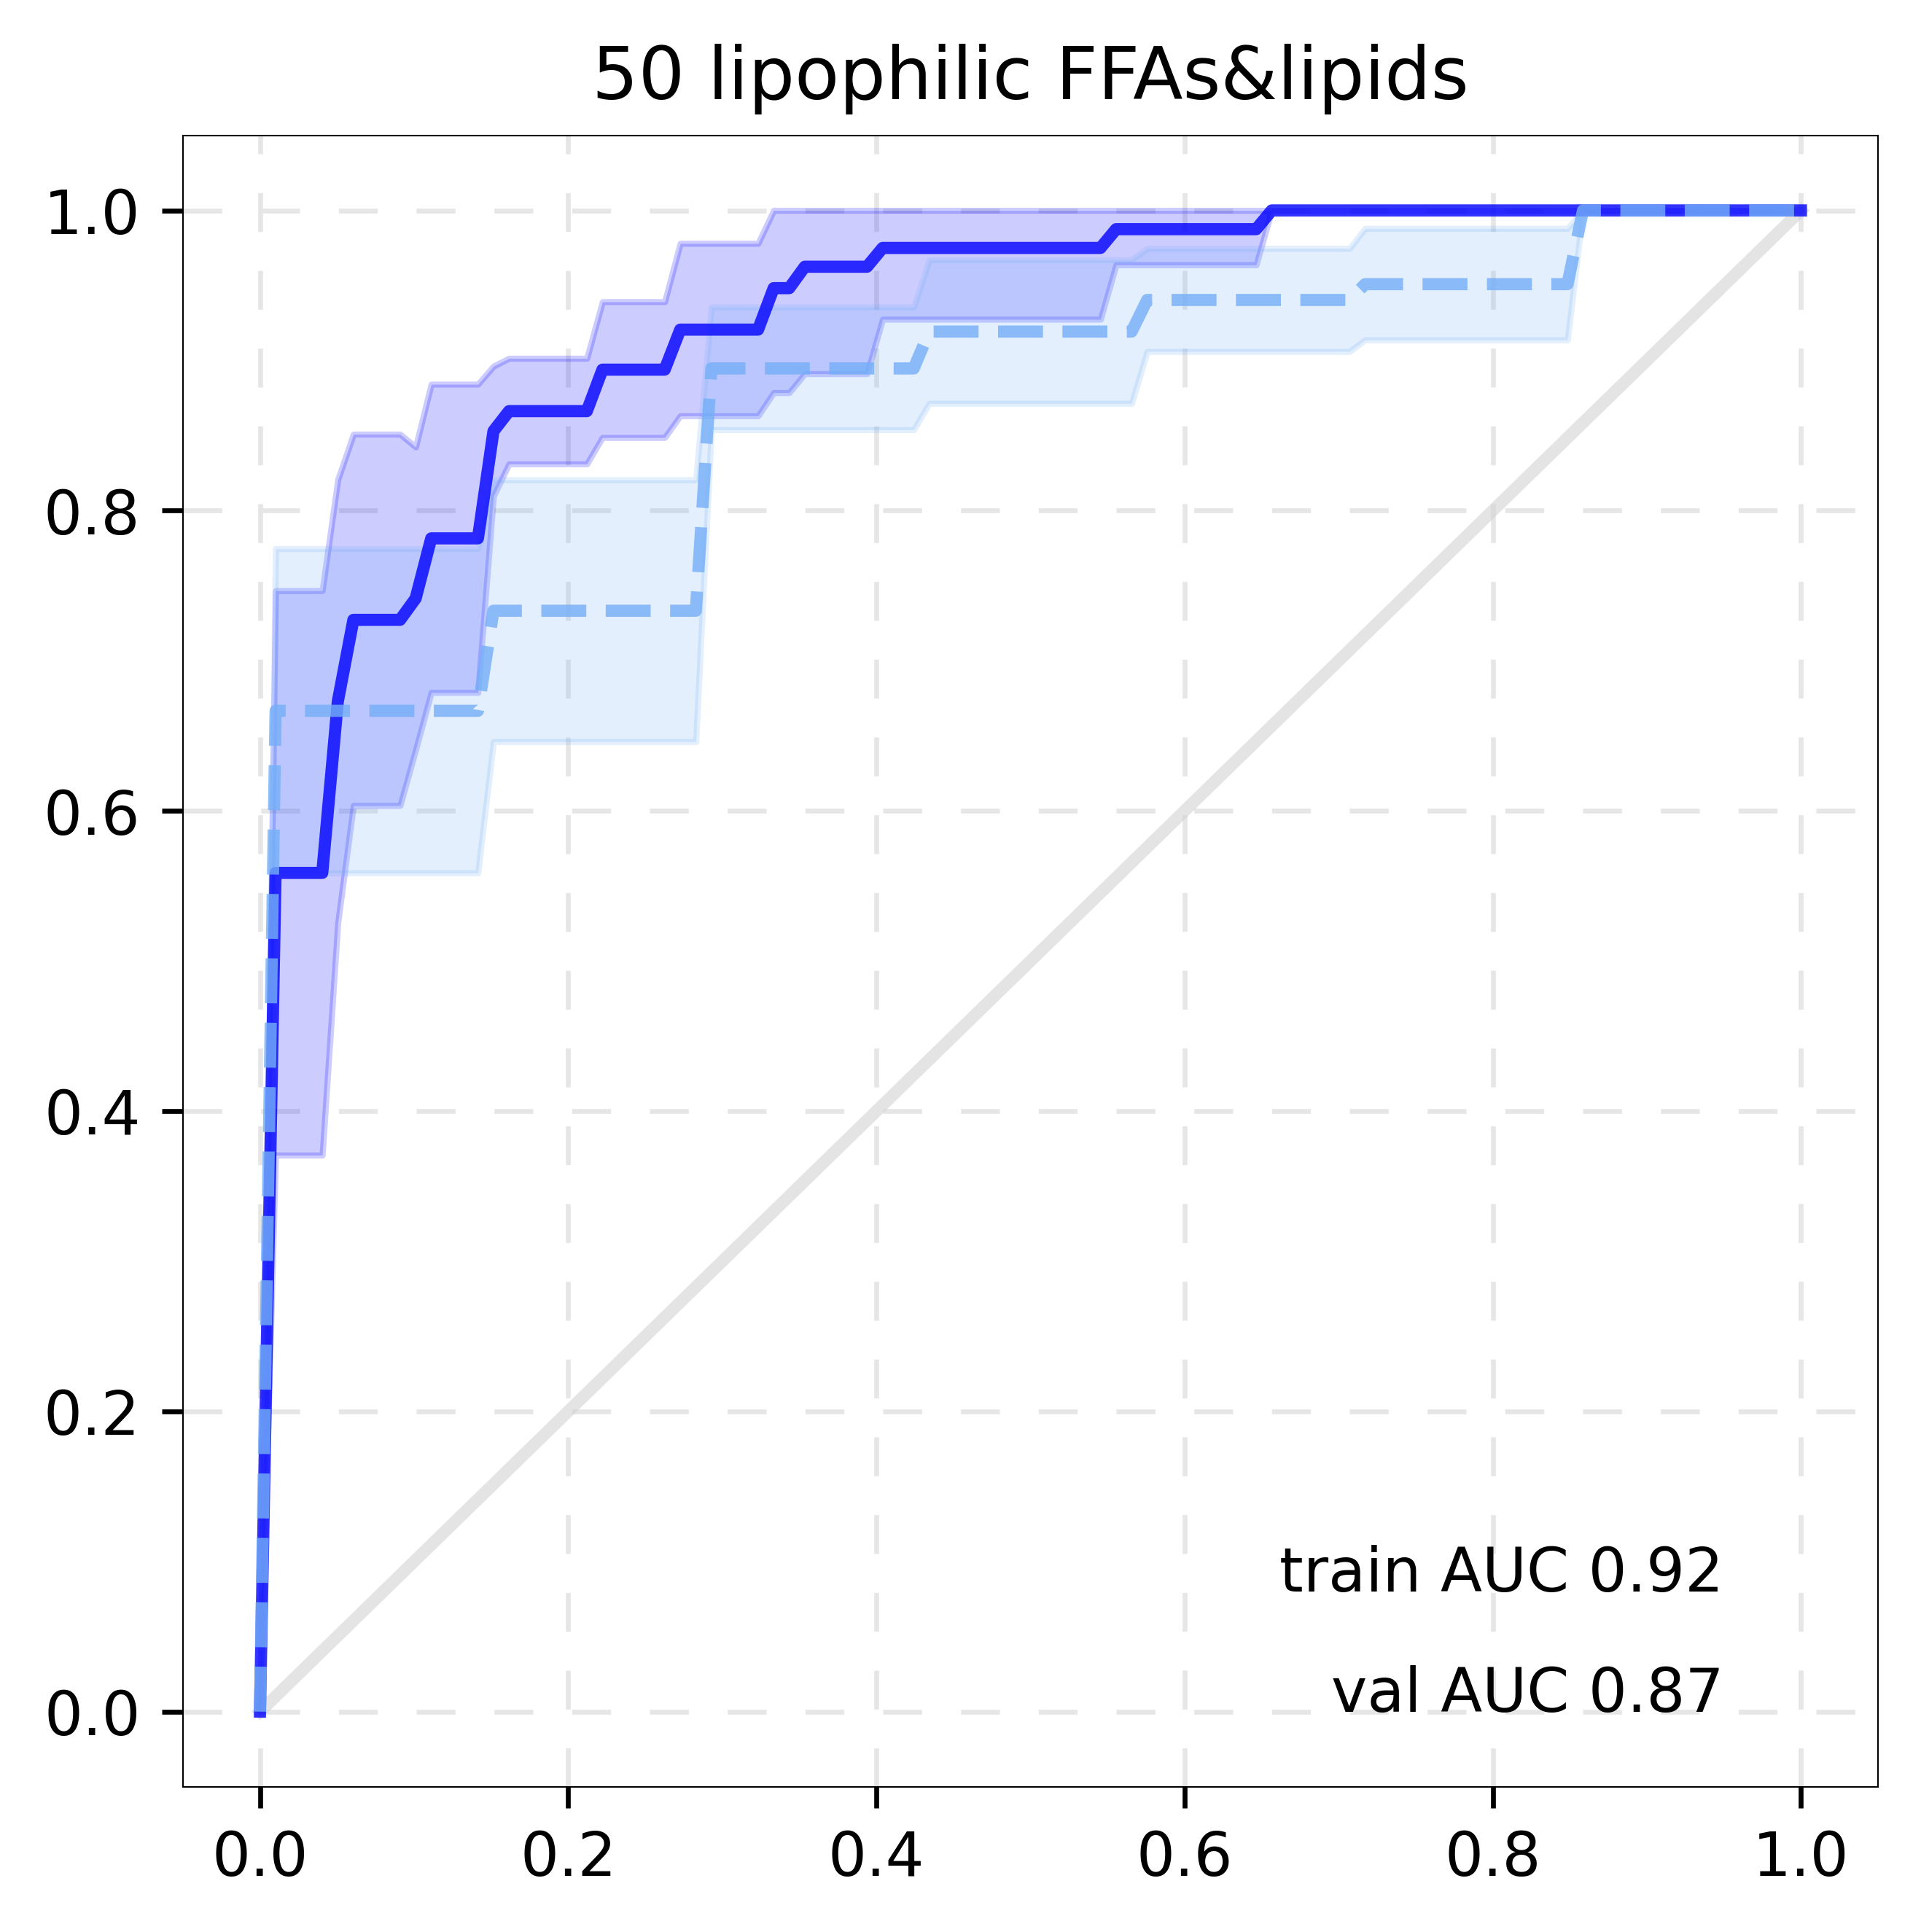

In [46]:
# all lipophilic metabolites
df_save = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_lipophilic_oeme, title=all_lip, modelname=modelname, drift=drift, hyper_param=hyper_param, plots=False, studies=studies)
df_results = pd.concat([df_results,df_save])

### calculate XGB with not drift corrected data

In [47]:
drift='drift'

Results for xg and drift for all suitable metabolites(not drift corrected)
Train Sensitivity:  0.8941176470588235  Specificity:  0.7738095238095237  Accuracy:  0.834319526627219  Balanced Accuracy:  0.8339635854341736
Validation Sensitivity:  0.264  Specificity:  0.9897435897435898  Accuracy:  0.70625  Balanced Accuracy:  0.6268717948717949
Joint Sensitivity:  0.5190476190476191  Specificity:  0.9247311827956989  Accuracy:  0.7505112474437629  Balanced Accuracy:  0.721889400921659


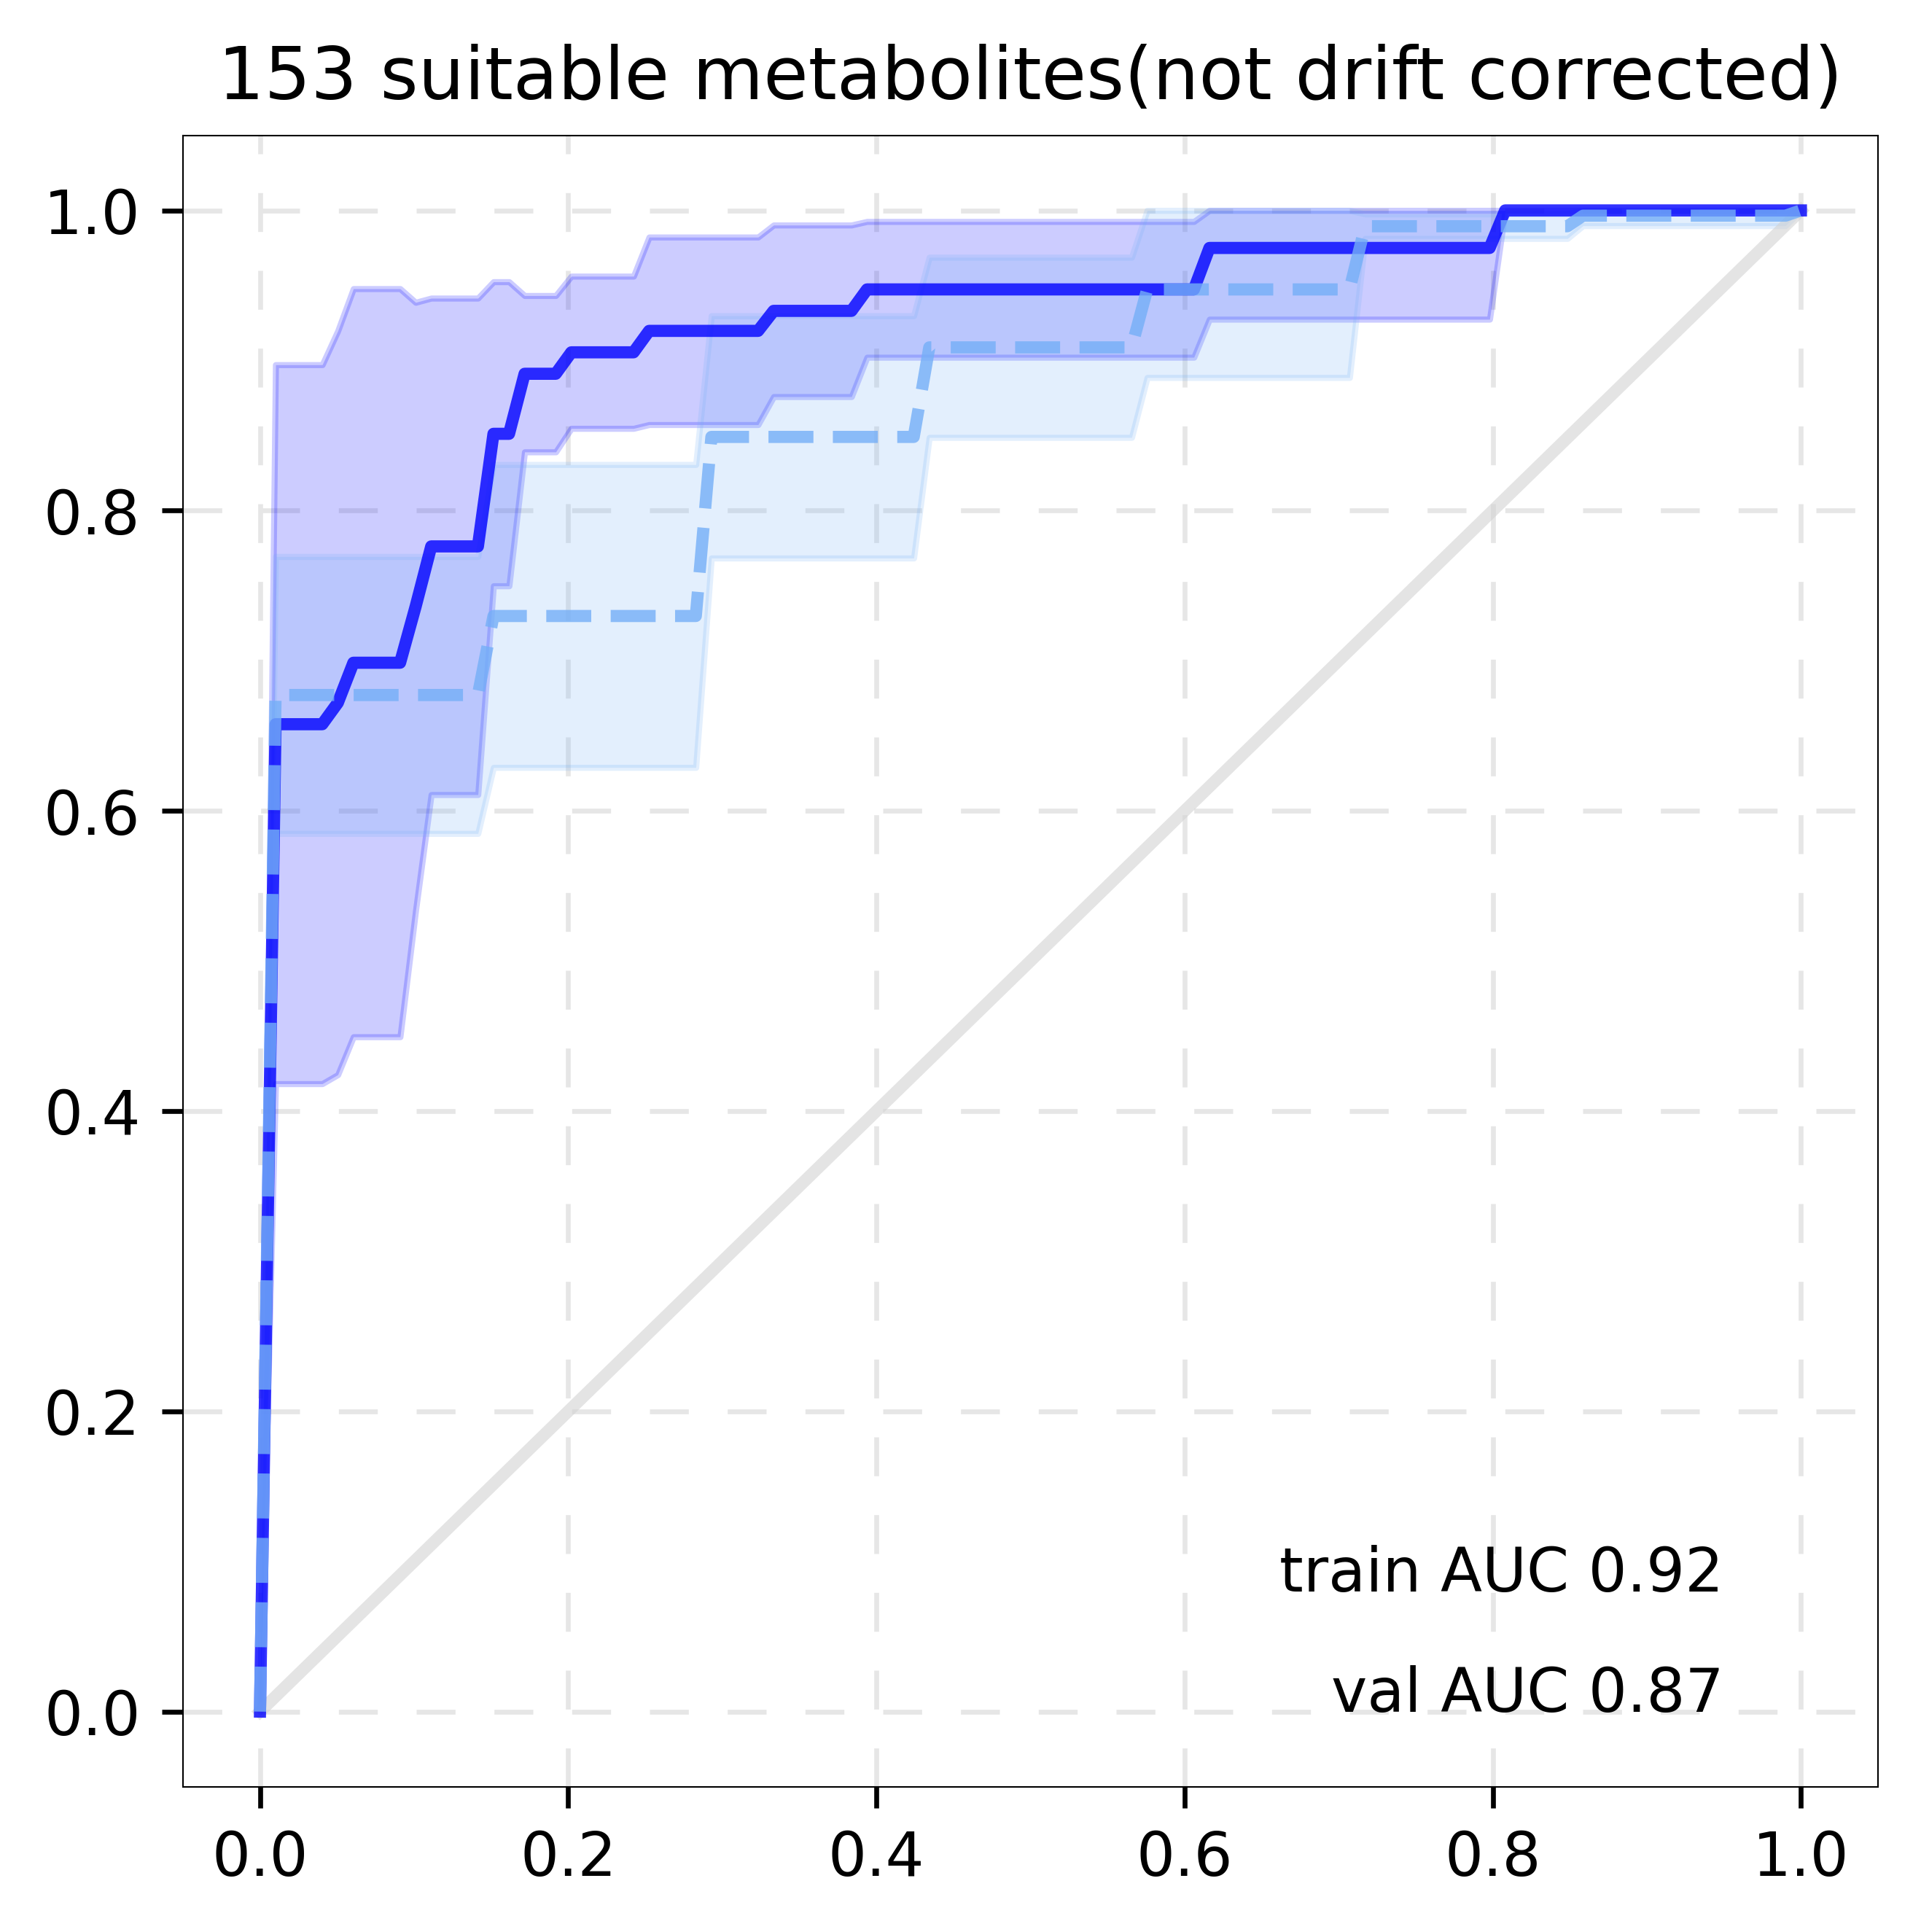

In [48]:
# all suitable metabolites
df_save = test_model(df_train_new, df_val_new, col_OE, title=all_metab+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param, plots=False, studies=studies)
df_results = pd.concat([df_results,df_save])

Results for xg and drift for all hydrophilic metabolites(not drift corrected)
Train Sensitivity:  0.8526315789473684  Specificity:  0.8108108108108107  Accuracy:  0.834319526627219  Balanced Accuracy:  0.8317211948790896
Validation Sensitivity:  0.24647887323943662  Specificity:  1.0  Accuracy:  0.665625  Balanced Accuracy:  0.6232394366197183
Joint Sensitivity:  0.48945147679324896  Specificity:  0.9444444444444445  Accuracy:  0.7239263803680982  Balanced Accuracy:  0.7169479606188467


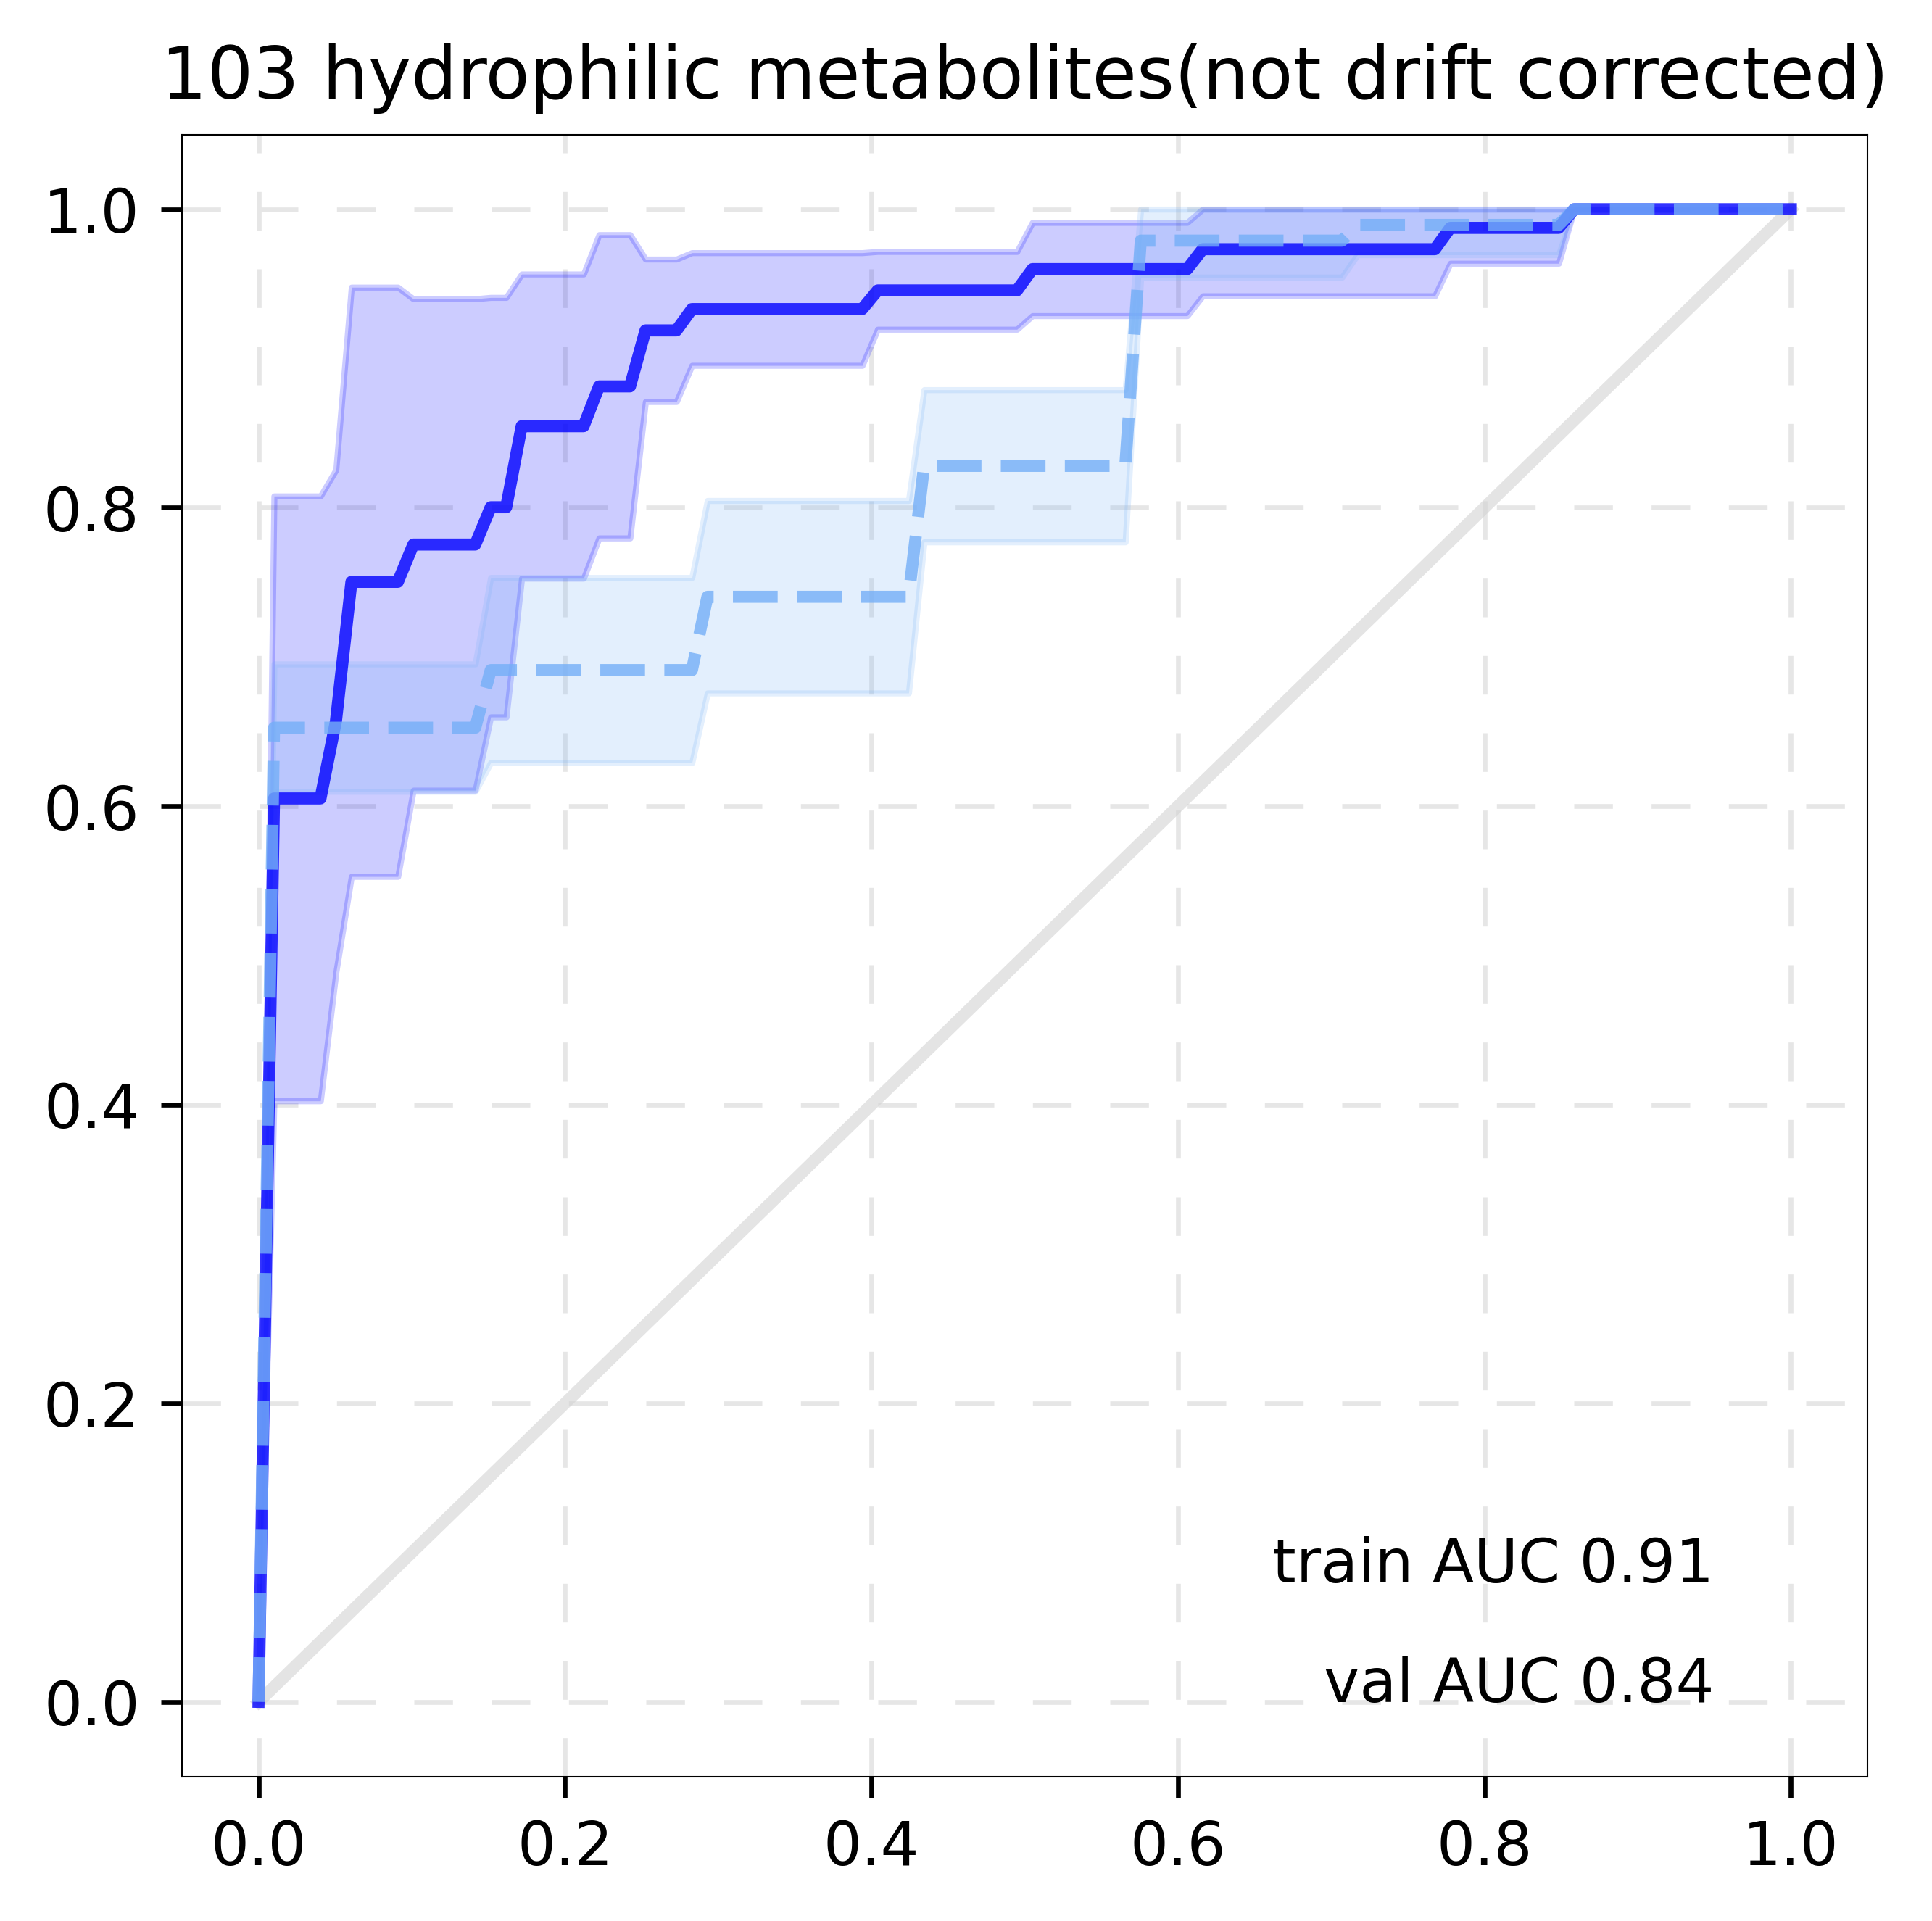

In [49]:
# all hydrophilic metabolites
df_save = test_model(df_train_new, df_val_new, col_hydrophilic_oe, title=all_hyd+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param, plots=False, studies=studies)
df_results = pd.concat([df_results,df_save])

Results for xg and drift for all lipophilic FFAs&lipids(not drift corrected)
Train Sensitivity:  0.8507462686567164  Specificity:  0.627450980392157  Accuracy:  0.7159763313609468  Balanced Accuracy:  0.7390986245244366
Validation Sensitivity:  0.2873563218390805  Specificity:  0.9570815450643777  Accuracy:  0.775  Balanced Accuracy:  0.6222189334517291
Joint Sensitivity:  0.5324675324675324  Specificity:  0.8567164179104477  Accuracy:  0.7546012269938649  Balanced Accuracy:  0.6945919751889901


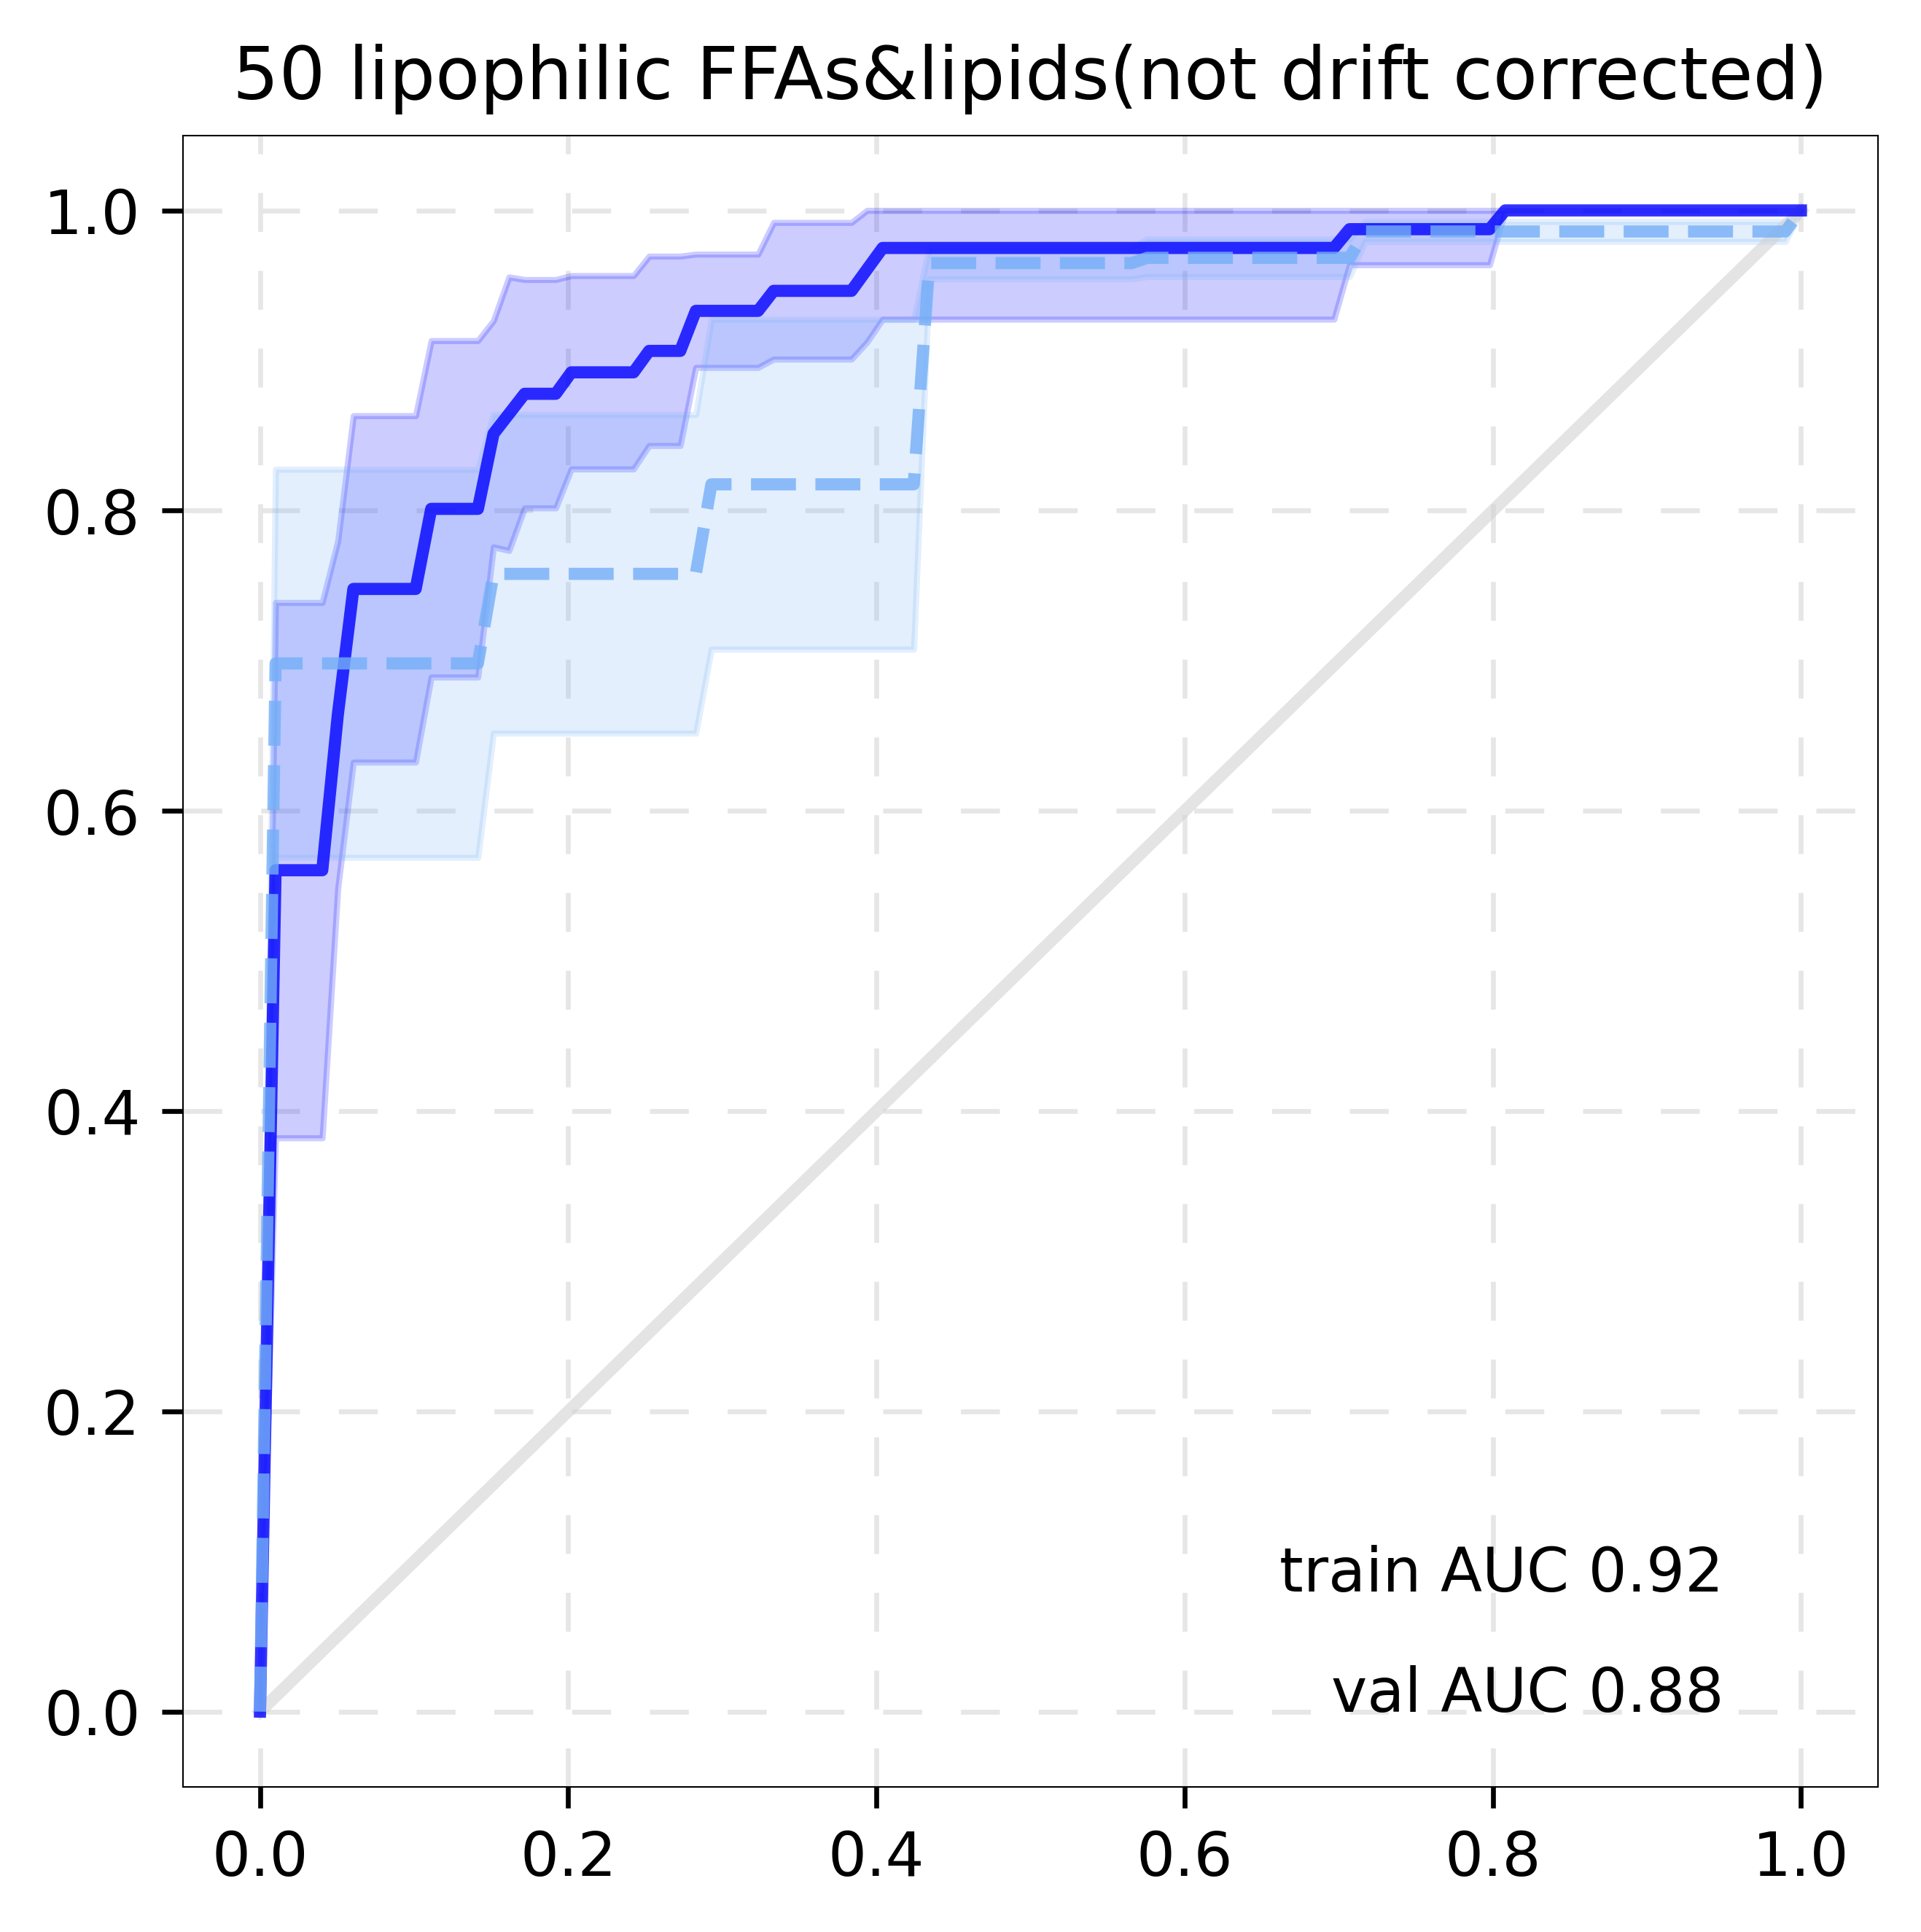

In [50]:
# all lipophilic metabolites
df_save = test_model(df_train_new, df_val_new, col_lipophilic_oe, title=all_lip+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param, plots=False, studies=studies)
df_results = pd.concat([df_results,df_save])

### All results of the calculations

In [51]:
df_results

,test_Sensitivity,test_Specificity,test_Accuracy,test_BACC,val_Sensitivity,val_Specificity,val_Accuracy,val_BACC,joint_Sensitivity,joint_Specificity,joint_Accuracy,joint_BACC,test_AUC,val_AUC,joint_AUC
rfdrift correctionsuitable metabolites,0.919540,0.817073,0.869822,0.868307,0.217949,0.993902,0.615625,0.605926,0.469136,0.934959,0.703476,0.702048,0.956360,0.827485,0.891923
rfdrift correctionhydrophilic metabolites,0.857143,0.729412,0.792899,0.793277,0.176056,0.943820,0.603125,0.559938,0.429204,0.874525,0.668712,0.651864,0.936760,0.750095,0.843427
rfdrift correctionlipophilic FFAs&lipids,0.902174,0.844156,0.875740,0.873165,0.208333,1.000000,0.584375,0.604167,0.453846,0.947598,0.685072,0.700722,0.950999,0.929199,0.940099
rfdriftsuitable metabolites(not drift corrected),0.939759,0.802326,0.869822,0.871042,0.240741,0.957547,0.715625,0.599144,0.544503,0.912752,0.768916,0.728627,0.945788,0.840138,0.892963
rfdrifthydrophilic metabolites(not drift corrected),0.872093,0.759036,0.816568,0.815565,0.181034,0.931373,0.659375,0.556204,0.475248,0.881533,0.713701,0.678390,0.941039,0.794985,0.868012
rfdriftlipophilic FFAs&lipids(not drift corrected),0.896104,0.717391,0.798817,0.806748,0.336634,0.995434,0.787500,0.666034,0.578652,0.913183,0.791411,0.745917,0.938313,0.931437,0.934875
xgdrift correctionsuitable metabolites,0.833333,0.850746,0.840237,0.842040,0.190217,1.000000,0.534375,0.595109,0.419580,0.950739,0.640082,0.685160,0.924012,0.838650,0.881331
xgdrift correctionhydrophilic metabolites,0.842105,0.797297,0.822485,0.819701,0.202312,1.000000,0.568750,0.601156,0.429104,0.932127,0.656442,0.680616,0.898487,0.752809,0.825648
xgdrift correctionlipophilic FFAs&lipids,0.825243,0.848485,0.834320,0.836864,0.177665,1.000000,0.493750,0.588832,0.400000,0.947090,0.611452,0.673545,0.923611,0.868421,0.896016
xgdriftsuitable metabolites(not drift corrected),0.894118,0.773810,0.834320,0.833964,0.264000,0.989744,0.706250,0.626872,0.519048,0.924731,0.750511,0.721889,0.915819,0.867429,0.891624


In [52]:
df_results.to_excel(str(seed)+'_ML_statistics.xlsx')